In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

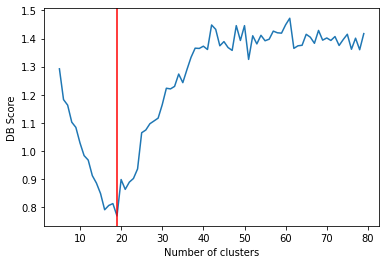

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

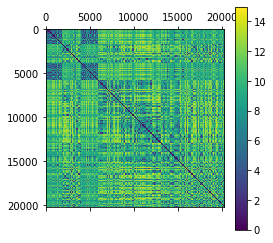

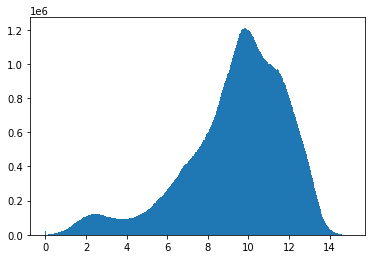

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

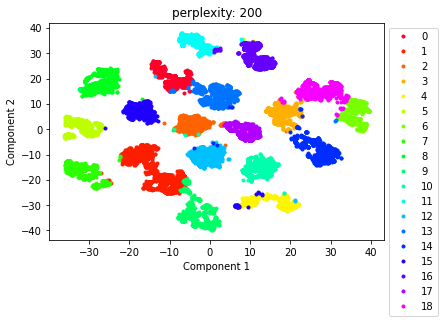

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9956635292958163


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.09756676718002684
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.8035220994475138
layer 6: 0.6489986187845305
layer 7: 0.46357044198895037
layer 8: 0.23564830801104975
layer 9: 0.1371395890883978
layer 10: 0.06277516401933703
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.942 | Reg loss: 0.021 | Tree loss: 2.942 | Accuracy: 0.104000 | 12.754 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.936 | Reg loss: 0.020 | Tree loss: 2.936 | Accuracy: 0.098500 | 11.47 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.926 | Reg loss: 0.020 | Tree loss: 2.926 | Accuracy: 0.103500 | 11.82 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.922 | Reg loss: 0.020 | Tree loss: 2.922 | Accuracy: 0.105500 | 11.492 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.917 | Reg loss: 0.019 | Tree loss: 2.917 | Accuracy: 0.102500 | 11.954 sec/iter
Epoch: 00 | Batch: 005 / 011 

Epoch: 04 | Batch: 008 / 011 | Total loss: 2.841 | Reg loss: 0.016 | Tree loss: 2.841 | Accuracy: 0.248000 | 12.615 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 2.827 | Reg loss: 0.017 | Tree loss: 2.827 | Accuracy: 0.249500 | 12.662 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 2.848 | Reg loss: 0.017 | Tree loss: 2.848 | Accuracy: 0.211604 | 12.49 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.925 | Reg loss: 0.015 | Tree loss: 2.925 | Accuracy: 0.094500 | 12.589 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.917 | Reg loss: 0.015 | Tree loss: 2.917 | Accuracy: 0.095000 | 12.632 sec/iter
Epoch: 05 | Batch: 002 / 011

Epoch: 09 | Batch: 005 / 011 | Total loss: 2.718 | Reg loss: 0.017 | Tree loss: 2.718 | Accuracy: 0.220000 | 12.848 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 2.688 | Reg loss: 0.018 | Tree loss: 2.688 | Accuracy: 0.217500 | 12.819 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 2.665 | Reg loss: 0.018 | Tree loss: 2.665 | Accuracy: 0.226500 | 12.84 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 2.641 | Reg loss: 0.018 | Tree loss: 2.641 | Accuracy: 0.225500 | 12.862 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 2.632 | Reg loss: 0.018 | Tree loss: 2.632 | Accuracy: 0.242500 | 12.834 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 2.647 | Reg loss: 0.019 | Tree loss: 2.647 | Accuracy: 0.204778 | 12.754 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 14 | Batch: 002 / 011 | Total loss: 2.647 | Reg loss: 0.019 | Tree loss: 2.647 | Accuracy: 0.227500 | 12.431 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 2.597 | Reg loss: 0.020 | Tree loss: 2.597 | Accuracy: 0.240500 | 12.434 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 2.571 | Reg loss: 0.020 | Tree loss: 2.571 | Accuracy: 0.218000 | 12.422 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 2.517 | Reg loss: 0.020 | Tree loss: 2.517 | Accuracy: 0.230000 | 12.424 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 2.484 | Reg loss: 0.020 | Tree loss: 2.484 | Accuracy: 0.232000 | 12.413 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 2.472 | Reg loss: 0.020 | Tree loss: 2.472 | Accuracy: 0.221000 | 12.417 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 2.446 | Reg loss: 0.020 | Tree loss: 2.446 | Accuracy: 0.255500 | 12.404 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 2.428 | Reg loss: 0.020 | Tree loss: 2.428 | Accuracy: 0.257500 | 12.409 sec/iter


layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 2.529 | Reg loss: 0.022 | Tree loss: 2.529 | Accuracy: 0.229000 | 12.396 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 2.480 | Reg loss: 0.022 | Tree loss: 2.480 | Accuracy: 0.264000 | 12.4 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 2.415 | Reg loss: 0.022 | Tree loss: 2.415 | Accuracy: 0.245500 | 12.412 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 2.373 | Reg loss: 0.022 | Tree loss: 2.373 | Accuracy: 0.243000 | 12.408 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 2.316 | Reg loss: 0.022 | Tree loss: 2.316 | Accuracy: 0.256500 | 12.413 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 2.255 | Reg loss: 0.022 | Tree loss: 2.255 | Accuracy: 0.274000 | 12.425 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 2.205 | Reg loss: 0.022 | Tree loss: 2.205 | Accuracy: 0.277000 | 12.437 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 2.201 | Reg loss: 0.022 | Tree loss: 2.201 | Accuracy: 

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 2.376 | Reg loss: 0.024 | Tree loss: 2.376 | Accuracy: 0.240000 | 12.503 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 2.323 | Reg loss: 0.024 | Tree loss: 2.323 | Accuracy: 0.266500 | 12.512 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 2.246 | Reg loss: 0.024 | Tree loss: 2.246 | Accuracy: 0.259500 | 12.522 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 2.216 | Reg loss: 0.024 | Tree loss: 2.216 | Accuracy: 0.262500 | 12.511 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 2.145 | Reg loss: 0.024 | Tree loss: 2.145 | Accuracy: 0.299500 | 12.52 sec/iter
Epoch: 24 | Batch: 005 / 011

Epoch: 28 | Batch: 008 / 011 | Total loss: 1.937 | Reg loss: 0.025 | Tree loss: 1.937 | Accuracy: 0.370500 | 12.401 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 1.918 | Reg loss: 0.025 | Tree loss: 1.918 | Accuracy: 0.367000 | 12.389 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 1.944 | Reg loss: 0.025 | Tree loss: 1.944 | Accuracy: 0.365188 | 12.362 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 2.290 | Reg loss: 0.025 | Tree loss: 2.290 | Accuracy: 0.272500 | 12.363 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 2.212 | Reg loss: 0.025 | Tree loss: 2.212 | Accuracy: 0.294000 | 12.366 sec/iter
Epoch: 29 | Batch: 002 / 01

Epoch: 33 | Batch: 005 / 011 | Total loss: 1.928 | Reg loss: 0.026 | Tree loss: 1.928 | Accuracy: 0.362000 | 12.25 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 1.910 | Reg loss: 0.026 | Tree loss: 1.910 | Accuracy: 0.372000 | 12.241 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 1.887 | Reg loss: 0.026 | Tree loss: 1.887 | Accuracy: 0.351500 | 12.244 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 1.886 | Reg loss: 0.026 | Tree loss: 1.886 | Accuracy: 0.356000 | 12.248 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 1.866 | Reg loss: 0.026 | Tree loss: 1.866 | Accuracy: 0.343500 | 12.238 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 1.828 | Reg loss: 0.026 | Tree loss: 1.828 | Accuracy: 0.412969 | 12.216 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 38 | Batch: 002 / 011 | Total loss: 2.027 | Reg loss: 0.027 | Tree loss: 2.027 | Accuracy: 0.308500 | 12.134 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 1.969 | Reg loss: 0.027 | Tree loss: 1.969 | Accuracy: 0.293500 | 12.135 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 1.919 | Reg loss: 0.027 | Tree loss: 1.919 | Accuracy: 0.352000 | 12.132 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 1.903 | Reg loss: 0.027 | Tree loss: 1.903 | Accuracy: 0.342000 | 12.135 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 1.820 | Reg loss: 0.027 | Tree loss: 1.820 | Accuracy: 0.400500 | 12.132 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 1.864 | Reg loss: 0.027 | Tree loss: 1.864 | Accuracy: 0.341000 | 12.135 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 1.825 | Reg loss: 0.027 | Tree loss: 1.825 | Accuracy: 0.355000 | 12.131 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 1.825 | Reg loss: 0.027 | Tree loss: 1.825 | Accuracy: 0.362000 | 12.131 sec/iter


Epoch: 43 | Batch: 000 / 011 | Total loss: 2.081 | Reg loss: 0.028 | Tree loss: 2.081 | Accuracy: 0.303000 | 12.059 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 2.057 | Reg loss: 0.028 | Tree loss: 2.057 | Accuracy: 0.303000 | 12.056 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 2.003 | Reg loss: 0.028 | Tree loss: 2.003 | Accuracy: 0.315000 | 12.058 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 1.927 | Reg loss: 0.028 | Tree loss: 1.927 | Accuracy: 0.311500 | 12.057 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 1.897 | Reg loss: 0.028 | Tree loss: 1.897 | Accuracy: 0.350000 | 12.059 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 1.832 | Reg loss: 0.028 | Tree loss: 1.832 | Accuracy: 0.368000 | 12.056 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 1.815 | Reg loss: 0.028 | Tree loss: 1.815 | Accuracy: 0.361500 | 12.058 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 1.789 | Reg loss: 0.028 | Tree loss: 1.789 | Accuracy: 0.373000 | 12.056 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 2.076 | Reg loss: 0.029 | Tree loss: 2.076 | Accuracy: 0.292000 | 11.999 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 2.006 | Reg loss: 0.029 | Tree loss: 2.006 | Accuracy: 0.296500 | 12.001 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 1.981 | Reg loss: 0.029 | Tree loss: 1.981 | Accuracy: 0.279000 | 11.998 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 1.912 | Reg loss: 0.029 | Tree loss: 1.912 | Accuracy: 0.325500 | 12.0 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 1.835 | Reg loss: 0.029 | Tree loss: 1.835 | Accuracy: 0.365000 | 11.999 sec/iter
Epoch: 48 | Batch: 005 / 011 

Epoch: 52 | Batch: 008 / 011 | Total loss: 1.739 | Reg loss: 0.030 | Tree loss: 1.739 | Accuracy: 0.364000 | 11.961 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 1.698 | Reg loss: 0.030 | Tree loss: 1.698 | Accuracy: 0.387500 | 11.961 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 1.687 | Reg loss: 0.030 | Tree loss: 1.687 | Accuracy: 0.392491 | 11.951 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 2.022 | Reg loss: 0.030 | Tree loss: 2.022 | Accuracy: 0.289500 | 11.955 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 1.980 | Reg loss: 0.030 | Tree loss: 1.980 | Accuracy: 0.302500 | 11.952 sec/iter
Epoch: 53 | Batch: 002 / 01

Epoch: 57 | Batch: 005 / 011 | Total loss: 1.766 | Reg loss: 0.030 | Tree loss: 1.766 | Accuracy: 0.375000 | 11.958 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 1.712 | Reg loss: 0.030 | Tree loss: 1.712 | Accuracy: 0.375000 | 11.954 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 1.712 | Reg loss: 0.030 | Tree loss: 1.712 | Accuracy: 0.352500 | 11.958 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 1.721 | Reg loss: 0.031 | Tree loss: 1.721 | Accuracy: 0.361000 | 11.962 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 1.695 | Reg loss: 0.031 | Tree loss: 1.695 | Accuracy: 0.379000 | 11.958 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 1.619 | Reg loss: 0.031 | Tree loss: 1.619 | Accuracy: 0.430034 | 11.946 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 1.839 | Reg loss: 0.031 | Tree loss: 1.839 | Accuracy: 0.344000 | 11.94 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.850 | Reg loss: 0.031 | Tree loss: 1.850 | Accuracy: 0.322500 | 11.935 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.795 | Reg loss: 0.031 | Tree loss: 1.795 | Accuracy: 0.354500 | 11.937 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.031 | Tree loss: 1.723 | Accuracy: 0.392500 | 11.94 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 1.714 | Reg loss: 0.031 | Tree loss: 1.714 | Accuracy: 0.376000 | 11.935 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 1.711 | Reg loss: 0.031 | Tree loss: 1.711 | Accuracy: 0.373500 | 11.937 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 1.664 | Reg loss: 0.031 | Tree loss: 1.664 | Accuracy: 0.398500 | 11.939 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 1.698 | Reg loss: 0.031 | Tree loss: 1.698 | Accuracy: 0.362500 | 11.935 sec/iter
Ep

Epoch: 67 | Batch: 000 / 011 | Total loss: 1.963 | Reg loss: 0.031 | Tree loss: 1.963 | Accuracy: 0.306500 | 11.897 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.895 | Reg loss: 0.031 | Tree loss: 1.895 | Accuracy: 0.316500 | 11.899 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.866 | Reg loss: 0.031 | Tree loss: 1.866 | Accuracy: 0.323000 | 11.897 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.809 | Reg loss: 0.032 | Tree loss: 1.809 | Accuracy: 0.350000 | 11.899 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.750 | Reg loss: 0.032 | Tree loss: 1.750 | Accuracy: 0.378000 | 11.898 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.736 | Reg loss: 0.032 | Tree loss: 1.736 | Accuracy: 0.360500 | 11.898 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.705 | Reg loss: 0.032 | Tree loss: 1.705 | Accuracy: 0.363500 | 11.897 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.702 | Reg loss: 0.032 | Tree loss: 1.702 | Accuracy: 0.359000 | 11.899 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 1.928 | Reg loss: 0.032 | Tree loss: 1.928 | Accuracy: 0.330000 | 11.743 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 1.873 | Reg loss: 0.032 | Tree loss: 1.873 | Accuracy: 0.333500 | 11.74 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 1.843 | Reg loss: 0.032 | Tree loss: 1.843 | Accuracy: 0.335000 | 11.737 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.808 | Reg loss: 0.032 | Tree loss: 1.808 | Accuracy: 0.350500 | 11.734 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.733 | Reg loss: 0.032 | Tree loss: 1.733 | Accuracy: 0.380000 | 11.731 sec/iter
Epoch: 72 | Batch: 005 / 011

Epoch: 76 | Batch: 008 / 011 | Total loss: 1.634 | Reg loss: 0.033 | Tree loss: 1.634 | Accuracy: 0.402000 | 11.581 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 1.618 | Reg loss: 0.033 | Tree loss: 1.618 | Accuracy: 0.402000 | 11.578 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 1.620 | Reg loss: 0.033 | Tree loss: 1.620 | Accuracy: 0.368601 | 11.568 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 1.913 | Reg loss: 0.032 | Tree loss: 1.913 | Accuracy: 0.319000 | 11.567 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 1.897 | Reg loss: 0.032 | Tree loss: 1.897 | Accuracy: 0.307500 | 11.564 sec/iter
Epoch: 77 | Batch: 002 / 01

Epoch: 81 | Batch: 005 / 011 | Total loss: 1.713 | Reg loss: 0.033 | Tree loss: 1.713 | Accuracy: 0.367500 | 11.43 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 1.666 | Reg loss: 0.033 | Tree loss: 1.666 | Accuracy: 0.380000 | 11.428 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 1.670 | Reg loss: 0.033 | Tree loss: 1.670 | Accuracy: 0.367500 | 11.426 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.387000 | 11.423 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 1.618 | Reg loss: 0.033 | Tree loss: 1.618 | Accuracy: 0.400000 | 11.421 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 1.634 | Reg loss: 0.033 | Tree loss: 1.634 | Accuracy: 0.385666 | 11.412 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 86 | Batch: 002 / 011 | Total loss: 1.785 | Reg loss: 0.033 | Tree loss: 1.785 | Accuracy: 0.349500 | 11.295 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 1.775 | Reg loss: 0.033 | Tree loss: 1.775 | Accuracy: 0.338500 | 11.293 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 1.706 | Reg loss: 0.033 | Tree loss: 1.706 | Accuracy: 0.382000 | 11.291 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 1.672 | Reg loss: 0.033 | Tree loss: 1.672 | Accuracy: 0.396000 | 11.289 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.372500 | 11.287 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.376000 | 11.285 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 1.613 | Reg loss: 0.033 | Tree loss: 1.613 | Accuracy: 0.388500 | 11.284 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 1.609 | Reg loss: 0.033 | Tree loss: 1.609 | Accuracy: 0.411000 | 11.282 sec/iter


Epoch: 91 | Batch: 000 / 011 | Total loss: 1.896 | Reg loss: 0.034 | Tree loss: 1.896 | Accuracy: 0.322500 | 11.168 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 1.868 | Reg loss: 0.034 | Tree loss: 1.868 | Accuracy: 0.325000 | 11.165 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 1.799 | Reg loss: 0.034 | Tree loss: 1.799 | Accuracy: 0.353500 | 11.162 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 1.751 | Reg loss: 0.034 | Tree loss: 1.751 | Accuracy: 0.368500 | 11.159 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 1.714 | Reg loss: 0.034 | Tree loss: 1.714 | Accuracy: 0.383500 | 11.156 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 1.652 | Reg loss: 0.034 | Tree loss: 1.652 | Accuracy: 0.397000 | 11.153 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 1.640 | Reg loss: 0.034 | Tree loss: 1.640 | Accuracy: 0.385000 | 11.15 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 1.652 | Reg loss: 0.034 | Tree loss: 1.652 | Accuracy: 0.387500 | 11.147 sec/iter
E

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 1.918 | Reg loss: 0.034 | Tree loss: 1.918 | Accuracy: 0.314500 | 10.982 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.034 | Tree loss: 1.830 | Accuracy: 0.340000 | 10.979 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 1.753 | Reg loss: 0.034 | Tree loss: 1.753 | Accuracy: 0.363000 | 10.976 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 1.739 | Reg loss: 0.034 | Tree loss: 1.739 | Accuracy: 0.379000 | 10.974 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 1.704 | Reg loss: 0.034 | Tree loss: 1.704 | Accuracy: 0.378500 | 10.971 sec/iter
Epoch: 96 | Batch: 005 / 01

Epoch: 100 | Batch: 008 / 011 | Total loss: 1.605 | Reg loss: 0.034 | Tree loss: 1.605 | Accuracy: 0.400000 | 10.826 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 1.582 | Reg loss: 0.034 | Tree loss: 1.582 | Accuracy: 0.419000 | 10.823 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 1.611 | Reg loss: 0.034 | Tree loss: 1.611 | Accuracy: 0.399317 | 10.816 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 1.853 | Reg loss: 0.034 | Tree loss: 1.853 | Accuracy: 0.333000 | 10.814 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 1.839 | Reg loss: 0.034 | Tree loss: 1.839 | Accuracy: 0.328000 | 10.811 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 005 / 011 | Total loss: 1.638 | Reg loss: 0.035 | Tree loss: 1.638 | Accuracy: 0.395500 | 10.679 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 1.624 | Reg loss: 0.035 | Tree loss: 1.624 | Accuracy: 0.414500 | 10.677 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 1.612 | Reg loss: 0.035 | Tree loss: 1.612 | Accuracy: 0.425500 | 10.674 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 1.595 | Reg loss: 0.035 | Tree loss: 1.595 | Accuracy: 0.426000 | 10.672 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 1.596 | Reg loss: 0.035 | Tree loss: 1.596 | Accuracy: 0.424500 | 10.67 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 1.595 | Reg loss: 0.035 | Tree loss: 1.595 | Accuracy: 0.453925 | 10.663 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 110 | Batch: 002 / 011 | Total loss: 1.781 | Reg loss: 0.035 | Tree loss: 1.781 | Accuracy: 0.346000 | 10.546 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.732 | Reg loss: 0.035 | Tree loss: 1.732 | Accuracy: 0.374000 | 10.544 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 1.685 | Reg loss: 0.035 | Tree loss: 1.685 | Accuracy: 0.392000 | 10.541 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 1.625 | Reg loss: 0.035 | Tree loss: 1.625 | Accuracy: 0.394500 | 10.539 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 1.614 | Reg loss: 0.035 | Tree loss: 1.614 | Accuracy: 0.401500 | 10.537 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 1.597 | Reg loss: 0.035 | Tree loss: 1.597 | Accuracy: 0.411000 | 10.536 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 1.585 | Reg loss: 0.035 | Tree loss: 1.585 | Accuracy: 0.417000 | 10.534 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 1.586 | Reg loss: 0.035 | Tree loss: 1.586 | Accuracy: 0.432000 | 10.532 s

Epoch: 115 | Batch: 000 / 011 | Total loss: 1.848 | Reg loss: 0.035 | Tree loss: 1.848 | Accuracy: 0.347500 | 10.474 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.808 | Reg loss: 0.035 | Tree loss: 1.808 | Accuracy: 0.341000 | 10.474 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.772 | Reg loss: 0.035 | Tree loss: 1.772 | Accuracy: 0.339500 | 10.474 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 1.709 | Reg loss: 0.035 | Tree loss: 1.709 | Accuracy: 0.378000 | 10.473 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 1.660 | Reg loss: 0.035 | Tree loss: 1.660 | Accuracy: 0.393000 | 10.472 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 1.659 | Reg loss: 0.035 | Tree loss: 1.659 | Accuracy: 0.387500 | 10.472 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 1.620 | Reg loss: 0.035 | Tree loss: 1.620 | Accuracy: 0.433000 | 10.473 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 1.602 | Reg loss: 0.035 | Tree loss: 1.602 | Accuracy: 0.407500 | 10.473 s

Epoch: 119 | Batch: 010 / 011 | Total loss: 1.526 | Reg loss: 0.035 | Tree loss: 1.526 | Accuracy: 0.464164 | 10.462 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 1.879 | Reg loss: 0.035 | Tree loss: 1.879 | Accuracy: 0.354500 | 10.462 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.797 | Reg loss: 0.035 | Tree loss: 1.797 | Accuracy: 0.352000 | 10.462 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.035 | Tree loss: 1.761 | Accuracy: 0.350500 | 10.462 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 1.707 | Reg loss: 0.035 | Tree loss: 1.707 | Accuracy: 0.378000 | 10.462 sec/iter
Epoch: 120 | Batch: 00

Epoch: 124 | Batch: 007 / 011 | Total loss: 1.600 | Reg loss: 0.036 | Tree loss: 1.600 | Accuracy: 0.437000 | 10.455 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 1.595 | Reg loss: 0.036 | Tree loss: 1.595 | Accuracy: 0.429500 | 10.456 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 1.563 | Reg loss: 0.036 | Tree loss: 1.563 | Accuracy: 0.444000 | 10.456 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 1.523 | Reg loss: 0.036 | Tree loss: 1.523 | Accuracy: 0.470990 | 10.454 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 1.847 | Reg loss: 0.035 | Tree loss: 1.847 | Accuracy: 0.345500 | 10.455 sec/iter
Epoch: 125 | Batch: 00

Epoch: 129 | Batch: 004 / 011 | Total loss: 1.661 | Reg loss: 0.036 | Tree loss: 1.661 | Accuracy: 0.390500 | 10.413 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 1.634 | Reg loss: 0.036 | Tree loss: 1.634 | Accuracy: 0.407500 | 10.413 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 1.581 | Reg loss: 0.036 | Tree loss: 1.581 | Accuracy: 0.442000 | 10.413 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 1.603 | Reg loss: 0.036 | Tree loss: 1.603 | Accuracy: 0.433000 | 10.413 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 1.590 | Reg loss: 0.036 | Tree loss: 1.590 | Accuracy: 0.429500 | 10.413 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 1.572 | Reg loss: 0.036 | Tree loss: 1.572 | Accuracy: 0.444500 | 10.413 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 1.511 | Reg loss: 0.036 | Tree loss: 1.511 | Accuracy: 0.501706 | 10.408 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 134 | Batch: 001 / 011 | Total loss: 1.782 | Reg loss: 0.036 | Tree loss: 1.782 | Accuracy: 0.345000 | 10.399 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 1.722 | Reg loss: 0.036 | Tree loss: 1.722 | Accuracy: 0.359000 | 10.398 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 1.708 | Reg loss: 0.036 | Tree loss: 1.708 | Accuracy: 0.362000 | 10.398 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 1.654 | Reg loss: 0.036 | Tree loss: 1.654 | Accuracy: 0.380500 | 10.397 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 1.612 | Reg loss: 0.036 | Tree loss: 1.612 | Accuracy: 0.412500 | 10.397 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.605 | Reg loss: 0.036 | Tree loss: 1.605 | Accuracy: 0.422500 | 10.396 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 1.606 | Reg loss: 0.036 | Tree loss: 1.606 | Accuracy: 0.416000 | 10.396 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 1.574 | Reg loss: 0.036 | Tree loss: 1.574 | Accuracy: 0.450500 | 10.395 s

layer 10: 0.9723756906077345
Epoch: 139 | Batch: 000 / 011 | Total loss: 1.833 | Reg loss: 0.036 | Tree loss: 1.833 | Accuracy: 0.355000 | 10.371 sec/iter
Epoch: 139 | Batch: 001 / 011 | Total loss: 1.773 | Reg loss: 0.036 | Tree loss: 1.773 | Accuracy: 0.349000 | 10.371 sec/iter
Epoch: 139 | Batch: 002 / 011 | Total loss: 1.745 | Reg loss: 0.036 | Tree loss: 1.745 | Accuracy: 0.358500 | 10.371 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 1.698 | Reg loss: 0.036 | Tree loss: 1.698 | Accuracy: 0.381500 | 10.371 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 1.668 | Reg loss: 0.036 | Tree loss: 1.668 | Accuracy: 0.377500 | 10.371 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 1.611 | Reg loss: 0.036 | Tree loss: 1.611 | Accuracy: 0.405500 | 10.372 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 1.598 | Reg loss: 0.036 | Tree loss: 1.598 | Accuracy: 0.437000 | 10.372 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 1.567 | Reg loss: 0.036 | Tree loss: 1.567 | 

Epoch: 143 | Batch: 010 / 011 | Total loss: 1.566 | Reg loss: 0.036 | Tree loss: 1.566 | Accuracy: 0.433447 | 10.37 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 144 | Batch: 000 / 011 | Total loss: 1.819 | Reg loss: 0.036 | Tree loss: 1.819 | Accuracy: 0.361500 | 10.372 sec/iter
Epoch: 144 | Batch: 001 / 011 | Total loss: 1.781 | Reg loss: 0.036 | Tree loss: 1.781 | Accuracy: 0.372000 | 10.372 sec/iter
Epoch: 144 | Batch: 002 / 011 | Total loss: 1.757 | Reg loss: 0.036 | Tree loss: 1.757 | Accuracy: 0.369000 | 10.372 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 1.699 | Reg loss: 0.036 | Tree loss: 1.699 | Accuracy: 0.383000 | 10.372 sec/iter
Epoch: 144 | Batch: 004

Epoch: 148 | Batch: 007 / 011 | Total loss: 1.589 | Reg loss: 0.036 | Tree loss: 1.589 | Accuracy: 0.430500 | 10.421 sec/iter
Epoch: 148 | Batch: 008 / 011 | Total loss: 1.567 | Reg loss: 0.036 | Tree loss: 1.567 | Accuracy: 0.445500 | 10.425 sec/iter
Epoch: 148 | Batch: 009 / 011 | Total loss: 1.579 | Reg loss: 0.037 | Tree loss: 1.579 | Accuracy: 0.440500 | 10.428 sec/iter
Epoch: 148 | Batch: 010 / 011 | Total loss: 1.599 | Reg loss: 0.037 | Tree loss: 1.599 | Accuracy: 0.423208 | 10.425 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 149 | Batch: 000 / 011 | Total loss: 1.796 | Reg loss: 0.036 | Tree loss: 1.796 | Accuracy: 0.360000 | 10.439 sec/iter
Epoch: 149 | Batch: 00

Epoch: 153 | Batch: 004 / 011 | Total loss: 1.654 | Reg loss: 0.037 | Tree loss: 1.654 | Accuracy: 0.383000 | 10.55 sec/iter
Epoch: 153 | Batch: 005 / 011 | Total loss: 1.628 | Reg loss: 0.037 | Tree loss: 1.628 | Accuracy: 0.391500 | 10.552 sec/iter
Epoch: 153 | Batch: 006 / 011 | Total loss: 1.608 | Reg loss: 0.037 | Tree loss: 1.608 | Accuracy: 0.429500 | 10.555 sec/iter
Epoch: 153 | Batch: 007 / 011 | Total loss: 1.580 | Reg loss: 0.037 | Tree loss: 1.580 | Accuracy: 0.410500 | 10.557 sec/iter
Epoch: 153 | Batch: 008 / 011 | Total loss: 1.576 | Reg loss: 0.037 | Tree loss: 1.576 | Accuracy: 0.416000 | 10.559 sec/iter
Epoch: 153 | Batch: 009 / 011 | Total loss: 1.528 | Reg loss: 0.037 | Tree loss: 1.528 | Accuracy: 0.456500 | 10.562 sec/iter
Epoch: 153 | Batch: 010 / 011 | Total loss: 1.536 | Reg loss: 0.037 | Tree loss: 1.536 | Accuracy: 0.440273 | 10.557 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 158 | Batch: 001 / 011 | Total loss: 1.777 | Reg loss: 0.037 | Tree loss: 1.777 | Accuracy: 0.371500 | 10.649 sec/iter
Epoch: 158 | Batch: 002 / 011 | Total loss: 1.708 | Reg loss: 0.037 | Tree loss: 1.708 | Accuracy: 0.361000 | 10.651 sec/iter
Epoch: 158 | Batch: 003 / 011 | Total loss: 1.698 | Reg loss: 0.037 | Tree loss: 1.698 | Accuracy: 0.381500 | 10.654 sec/iter
Epoch: 158 | Batch: 004 / 011 | Total loss: 1.671 | Reg loss: 0.037 | Tree loss: 1.671 | Accuracy: 0.380000 | 10.656 sec/iter
Epoch: 158 | Batch: 005 / 011 | Total loss: 1.602 | Reg loss: 0.037 | Tree loss: 1.602 | Accuracy: 0.409500 | 10.658 sec/iter
Epoch: 158 | Batch: 006 / 011 | Total loss: 1.578 | Reg loss: 0.037 | Tree loss: 1.578 | Accuracy: 0.428000 | 10.661 sec/iter
Epoch: 158 | Batch: 007 / 011 | Total loss: 1.580 | Reg loss: 0.037 | Tree loss: 1.580 | Accuracy: 0.431500 | 10.663 sec/iter
Epoch: 158 | Batch: 008 / 011 | Total loss: 1.560 | Reg loss: 0.037 | Tree loss: 1.560 | Accuracy: 0.451500 | 10.665 s

Epoch: 163 | Batch: 000 / 011 | Total loss: 1.785 | Reg loss: 0.037 | Tree loss: 1.785 | Accuracy: 0.374500 | 10.75 sec/iter
Epoch: 163 | Batch: 001 / 011 | Total loss: 1.762 | Reg loss: 0.037 | Tree loss: 1.762 | Accuracy: 0.362000 | 10.749 sec/iter
Epoch: 163 | Batch: 002 / 011 | Total loss: 1.715 | Reg loss: 0.037 | Tree loss: 1.715 | Accuracy: 0.372500 | 10.752 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 1.684 | Reg loss: 0.037 | Tree loss: 1.684 | Accuracy: 0.384500 | 10.754 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 1.636 | Reg loss: 0.037 | Tree loss: 1.636 | Accuracy: 0.400000 | 10.756 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 1.621 | Reg loss: 0.037 | Tree loss: 1.621 | Accuracy: 0.404500 | 10.758 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 1.597 | Reg loss: 0.037 | Tree loss: 1.597 | Accuracy: 0.429000 | 10.761 sec/iter
Epoch: 163 | Batch: 007 / 011 | Total loss: 1.572 | Reg loss: 0.037 | Tree loss: 1.572 | Accuracy: 0.440000 | 10.763 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 168 | Batch: 000 / 011 | Total loss: 1.788 | Reg loss: 0.037 | Tree loss: 1.788 | Accuracy: 0.383500 | 10.845 sec/iter
Epoch: 168 | Batch: 001 / 011 | Total loss: 1.762 | Reg loss: 0.037 | Tree loss: 1.762 | Accuracy: 0.378000 | 10.844 sec/iter
Epoch: 168 | Batch: 002 / 011 | Total loss: 1.730 | Reg loss: 0.037 | Tree loss: 1.730 | Accuracy: 0.363000 | 10.846 sec/iter
Epoch: 168 | Batch: 003 / 011 | Total loss: 1.675 | Reg loss: 0.037 | Tree loss: 1.675 | Accuracy: 0.384000 | 10.848 sec/iter
Epoch: 168 | Batch: 004 / 011 | Total loss: 1.610 | Reg loss: 0.037 | Tree loss: 1.610 | Accuracy: 0.387500 | 10.85 sec/iter
Epoch: 168 | Batch: 005

Epoch: 172 | Batch: 008 / 011 | Total loss: 1.572 | Reg loss: 0.037 | Tree loss: 1.572 | Accuracy: 0.438000 | 10.929 sec/iter
Epoch: 172 | Batch: 009 / 011 | Total loss: 1.535 | Reg loss: 0.037 | Tree loss: 1.535 | Accuracy: 0.462500 | 10.931 sec/iter
Epoch: 172 | Batch: 010 / 011 | Total loss: 1.495 | Reg loss: 0.037 | Tree loss: 1.495 | Accuracy: 0.477816 | 10.927 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 000 / 011 | Total loss: 1.806 | Reg loss: 0.037 | Tree loss: 1.806 | Accuracy: 0.372000 | 10.934 sec/iter
Epoch: 173 | Batch: 001 / 011 | Total loss: 1.754 | Reg loss: 0.037 | Tree loss: 1.754 | Accuracy: 0.379500 | 10.933 sec/iter
Epoch: 173 | Batch: 00

Epoch: 177 | Batch: 005 / 011 | Total loss: 1.578 | Reg loss: 0.037 | Tree loss: 1.578 | Accuracy: 0.429000 | 11.008 sec/iter
Epoch: 177 | Batch: 006 / 011 | Total loss: 1.601 | Reg loss: 0.037 | Tree loss: 1.601 | Accuracy: 0.428000 | 11.01 sec/iter
Epoch: 177 | Batch: 007 / 011 | Total loss: 1.576 | Reg loss: 0.037 | Tree loss: 1.576 | Accuracy: 0.416000 | 11.012 sec/iter
Epoch: 177 | Batch: 008 / 011 | Total loss: 1.529 | Reg loss: 0.037 | Tree loss: 1.529 | Accuracy: 0.468000 | 11.013 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 1.530 | Reg loss: 0.037 | Tree loss: 1.530 | Accuracy: 0.454000 | 11.015 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 1.523 | Reg loss: 0.037 | Tree loss: 1.523 | Accuracy: 0.488055 | 11.011 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 182 | Batch: 002 / 011 | Total loss: 1.700 | Reg loss: 0.037 | Tree loss: 1.700 | Accuracy: 0.369500 | 11.082 sec/iter
Epoch: 182 | Batch: 003 / 011 | Total loss: 1.670 | Reg loss: 0.037 | Tree loss: 1.670 | Accuracy: 0.401000 | 11.084 sec/iter
Epoch: 182 | Batch: 004 / 011 | Total loss: 1.623 | Reg loss: 0.037 | Tree loss: 1.623 | Accuracy: 0.399500 | 11.086 sec/iter
Epoch: 182 | Batch: 005 / 011 | Total loss: 1.612 | Reg loss: 0.037 | Tree loss: 1.612 | Accuracy: 0.408000 | 11.088 sec/iter
Epoch: 182 | Batch: 006 / 011 | Total loss: 1.576 | Reg loss: 0.037 | Tree loss: 1.576 | Accuracy: 0.451500 | 11.089 sec/iter
Epoch: 182 | Batch: 007 / 011 | Total loss: 1.556 | Reg loss: 0.037 | Tree loss: 1.556 | Accuracy: 0.435500 | 11.091 sec/iter
Epoch: 182 | Batch: 008 / 011 | Total loss: 1.533 | Reg loss: 0.037 | Tree loss: 1.533 | Accuracy: 0.470500 | 11.093 sec/iter
Epoch: 182 | Batch: 009 / 011 | Total loss: 1.552 | Reg loss: 0.038 | Tree loss: 1.552 | Accuracy: 0.462000 | 11.095 s

Epoch: 187 | Batch: 000 / 011 | Total loss: 1.789 | Reg loss: 0.037 | Tree loss: 1.789 | Accuracy: 0.370000 | 11.157 sec/iter
Epoch: 187 | Batch: 001 / 011 | Total loss: 1.755 | Reg loss: 0.037 | Tree loss: 1.755 | Accuracy: 0.370500 | 11.156 sec/iter
Epoch: 187 | Batch: 002 / 011 | Total loss: 1.699 | Reg loss: 0.037 | Tree loss: 1.699 | Accuracy: 0.391000 | 11.158 sec/iter
Epoch: 187 | Batch: 003 / 011 | Total loss: 1.667 | Reg loss: 0.038 | Tree loss: 1.667 | Accuracy: 0.392500 | 11.16 sec/iter
Epoch: 187 | Batch: 004 / 011 | Total loss: 1.634 | Reg loss: 0.038 | Tree loss: 1.634 | Accuracy: 0.432000 | 11.162 sec/iter
Epoch: 187 | Batch: 005 / 011 | Total loss: 1.576 | Reg loss: 0.038 | Tree loss: 1.576 | Accuracy: 0.439500 | 11.163 sec/iter
Epoch: 187 | Batch: 006 / 011 | Total loss: 1.550 | Reg loss: 0.038 | Tree loss: 1.550 | Accuracy: 0.442500 | 11.165 sec/iter
Epoch: 187 | Batch: 007 / 011 | Total loss: 1.540 | Reg loss: 0.038 | Tree loss: 1.540 | Accuracy: 0.436500 | 11.167 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 192 | Batch: 000 / 011 | Total loss: 1.773 | Reg loss: 0.038 | Tree loss: 1.773 | Accuracy: 0.379000 | 11.229 sec/iter
Epoch: 192 | Batch: 001 / 011 | Total loss: 1.744 | Reg loss: 0.038 | Tree loss: 1.744 | Accuracy: 0.391500 | 11.228 sec/iter
Epoch: 192 | Batch: 002 / 011 | Total loss: 1.692 | Reg loss: 0.038 | Tree loss: 1.692 | Accuracy: 0.377000 | 11.23 sec/iter
Epoch: 192 | Batch: 003 / 011 | Total loss: 1.658 | Reg loss: 0.038 | Tree loss: 1.658 | Accuracy: 0.414500 | 11.232 sec/iter
Epoch: 192 | Batch: 004 / 011 | Total loss: 1.602 | Reg loss: 0.038 | Tree loss: 1.602 | Accuracy: 0.433000 | 11.233 sec/iter
Epoch: 192 | Batch: 005

Epoch: 196 | Batch: 008 / 011 | Total loss: 1.525 | Reg loss: 0.038 | Tree loss: 1.525 | Accuracy: 0.456000 | 11.295 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 1.515 | Reg loss: 0.038 | Tree loss: 1.515 | Accuracy: 0.471000 | 11.297 sec/iter
Epoch: 196 | Batch: 010 / 011 | Total loss: 1.548 | Reg loss: 0.038 | Tree loss: 1.548 | Accuracy: 0.423208 | 11.293 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 197 | Batch: 000 / 011 | Total loss: 1.806 | Reg loss: 0.038 | Tree loss: 1.806 | Accuracy: 0.364500 | 11.301 sec/iter
Epoch: 197 | Batch: 001 / 011 | Total loss: 1.721 | Reg loss: 0.038 | Tree loss: 1.721 | Accuracy: 0.396000 | 11.301 sec/iter
Epoch: 197 | Batch: 00

Epoch: 201 | Batch: 005 / 011 | Total loss: 1.562 | Reg loss: 0.038 | Tree loss: 1.562 | Accuracy: 0.456000 | 11.37 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 1.541 | Reg loss: 0.038 | Tree loss: 1.541 | Accuracy: 0.450000 | 11.371 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 1.530 | Reg loss: 0.038 | Tree loss: 1.530 | Accuracy: 0.442500 | 11.373 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 1.530 | Reg loss: 0.038 | Tree loss: 1.530 | Accuracy: 0.473000 | 11.375 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 1.508 | Reg loss: 0.038 | Tree loss: 1.508 | Accuracy: 0.474500 | 11.377 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 1.489 | Reg loss: 0.038 | Tree loss: 1.489 | Accuracy: 0.484642 | 11.373 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 206 | Batch: 002 / 011 | Total loss: 1.698 | Reg loss: 0.038 | Tree loss: 1.698 | Accuracy: 0.388500 | 11.442 sec/iter
Epoch: 206 | Batch: 003 / 011 | Total loss: 1.655 | Reg loss: 0.038 | Tree loss: 1.655 | Accuracy: 0.408500 | 11.444 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 1.614 | Reg loss: 0.038 | Tree loss: 1.614 | Accuracy: 0.403000 | 11.446 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 1.550 | Reg loss: 0.038 | Tree loss: 1.550 | Accuracy: 0.443500 | 11.448 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 1.567 | Reg loss: 0.038 | Tree loss: 1.567 | Accuracy: 0.446500 | 11.449 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 1.521 | Reg loss: 0.038 | Tree loss: 1.521 | Accuracy: 0.464000 | 11.451 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 1.513 | Reg loss: 0.038 | Tree loss: 1.513 | Accuracy: 0.485500 | 11.453 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 1.501 | Reg loss: 0.038 | Tree loss: 1.501 | Accuracy: 0.494000 | 11.455 s

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 211 | Batch: 000 / 011 | Total loss: 1.776 | Reg loss: 0.038 | Tree loss: 1.776 | Accuracy: 0.388000 | 11.519 sec/iter
Epoch: 211 | Batch: 001 / 011 | Total loss: 1.722 | Reg loss: 0.038 | Tree loss: 1.722 | Accuracy: 0.368000 | 11.518 sec/iter
Epoch: 211 | Batch: 002 / 011 | Total loss: 1.671 | Reg loss: 0.038 | Tree loss: 1.671 | Accuracy: 0.400500 | 11.517 sec/iter
Epoch: 211 | Batch: 003 / 011 | Total loss: 1.641 | Reg loss: 0.038 | Tree loss: 1.641 | Accuracy: 0.399000 | 11.519 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 1.617 | Reg loss: 0.038 | Tree loss: 1.617 | Accuracy: 0.425500 | 11.521 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 1.569 | Reg loss: 0.038 | Tree loss: 1.569 | Accuracy: 0.433000 | 11.522 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 1.526 | Reg loss: 0.038 | Tree loss: 1.526 | Accuracy: 0.477000 | 11.524 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 1.547 | Reg loss:

Epoch: 215 | Batch: 010 / 011 | Total loss: 1.563 | Reg loss: 0.039 | Tree loss: 1.563 | Accuracy: 0.453925 | 11.583 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 216 | Batch: 000 / 011 | Total loss: 1.770 | Reg loss: 0.038 | Tree loss: 1.770 | Accuracy: 0.375000 | 11.591 sec/iter
Epoch: 216 | Batch: 001 / 011 | Total loss: 1.735 | Reg loss: 0.038 | Tree loss: 1.735 | Accuracy: 0.367000 | 11.59 sec/iter
Epoch: 216 | Batch: 002 / 011 | Total loss: 1.692 | Reg loss: 0.038 | Tree loss: 1.692 | Accuracy: 0.396500 | 11.589 sec/iter
Epoch: 216 | Batch: 003 / 011 | Total loss: 1.626 | Reg loss: 0.038 | Tree loss: 1.626 | Accuracy: 0.411500 | 11.59 sec/iter
Epoch: 216 | Batch: 004 

Epoch: 220 | Batch: 007 / 011 | Total loss: 1.502 | Reg loss: 0.039 | Tree loss: 1.502 | Accuracy: 0.445000 | 11.653 sec/iter
Epoch: 220 | Batch: 008 / 011 | Total loss: 1.524 | Reg loss: 0.039 | Tree loss: 1.524 | Accuracy: 0.448000 | 11.654 sec/iter
Epoch: 220 | Batch: 009 / 011 | Total loss: 1.520 | Reg loss: 0.039 | Tree loss: 1.520 | Accuracy: 0.458000 | 11.656 sec/iter
Epoch: 220 | Batch: 010 / 011 | Total loss: 1.442 | Reg loss: 0.039 | Tree loss: 1.442 | Accuracy: 0.529010 | 11.653 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 221 | Batch: 000 / 011 | Total loss: 1.770 | Reg loss: 0.038 | Tree loss: 1.770 | Accuracy: 0.393000 | 11.66 sec/iter
Epoch: 221 | Batch: 001

Epoch: 225 | Batch: 004 / 011 | Total loss: 1.631 | Reg loss: 0.039 | Tree loss: 1.631 | Accuracy: 0.423000 | 11.715 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 1.557 | Reg loss: 0.039 | Tree loss: 1.557 | Accuracy: 0.443500 | 11.716 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 1.567 | Reg loss: 0.039 | Tree loss: 1.567 | Accuracy: 0.436000 | 11.718 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 1.523 | Reg loss: 0.039 | Tree loss: 1.523 | Accuracy: 0.450000 | 11.719 sec/iter
Epoch: 225 | Batch: 008 / 011 | Total loss: 1.497 | Reg loss: 0.039 | Tree loss: 1.497 | Accuracy: 0.487500 | 11.721 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 1.505 | Reg loss: 0.039 | Tree loss: 1.505 | Accuracy: 0.460500 | 11.722 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 1.561 | Reg loss: 0.039 | Tree loss: 1.561 | Accuracy: 0.436860 | 11.719 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 230 | Batch: 001 / 011 | Total loss: 1.742 | Reg loss: 0.039 | Tree loss: 1.742 | Accuracy: 0.389000 | 11.777 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 1.705 | Reg loss: 0.039 | Tree loss: 1.705 | Accuracy: 0.379500 | 11.776 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 1.642 | Reg loss: 0.039 | Tree loss: 1.642 | Accuracy: 0.403500 | 11.777 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 1.590 | Reg loss: 0.039 | Tree loss: 1.590 | Accuracy: 0.439000 | 11.779 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 1.582 | Reg loss: 0.039 | Tree loss: 1.582 | Accuracy: 0.436500 | 11.781 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 1.538 | Reg loss: 0.039 | Tree loss: 1.538 | Accuracy: 0.441500 | 11.782 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 1.521 | Reg loss: 0.039 | Tree loss: 1.521 | Accuracy: 0.446500 | 11.784 sec/iter
Epoch: 230 | Batch: 008 / 011 | Total loss: 1.521 | Reg loss: 0.039 | Tree loss: 1.521 | Accuracy: 0.453500 | 11.785 s

layer 10: 0.9723756906077345
Epoch: 235 | Batch: 000 / 011 | Total loss: 1.750 | Reg loss: 0.039 | Tree loss: 1.750 | Accuracy: 0.398500 | 11.839 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 1.734 | Reg loss: 0.039 | Tree loss: 1.734 | Accuracy: 0.384500 | 11.838 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 1.693 | Reg loss: 0.039 | Tree loss: 1.693 | Accuracy: 0.390500 | 11.837 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 1.663 | Reg loss: 0.039 | Tree loss: 1.663 | Accuracy: 0.401000 | 11.838 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 1.597 | Reg loss: 0.039 | Tree loss: 1.597 | Accuracy: 0.426500 | 11.84 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 1.577 | Reg loss: 0.039 | Tree loss: 1.577 | Accuracy: 0.444500 | 11.841 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 1.536 | Reg loss: 0.039 | Tree loss: 1.536 | Accuracy: 0.443000 | 11.843 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 1.539 | Reg loss: 0.039 | Tree loss: 1.539 | A

Epoch: 239 | Batch: 010 / 011 | Total loss: 1.443 | Reg loss: 0.039 | Tree loss: 1.443 | Accuracy: 0.484642 | 11.89 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 240 | Batch: 000 / 011 | Total loss: 1.766 | Reg loss: 0.039 | Tree loss: 1.766 | Accuracy: 0.402000 | 11.896 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 1.735 | Reg loss: 0.039 | Tree loss: 1.735 | Accuracy: 0.371000 | 11.896 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 1.661 | Reg loss: 0.039 | Tree loss: 1.661 | Accuracy: 0.406500 | 11.895 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 1.663 | Reg loss: 0.039 | Tree loss: 1.663 | Accuracy: 0.392000 | 11.896 sec/iter
Epoch: 240 | Batch: 004

Epoch: 244 | Batch: 007 / 011 | Total loss: 1.514 | Reg loss: 0.039 | Tree loss: 1.514 | Accuracy: 0.458000 | 11.946 sec/iter
Epoch: 244 | Batch: 008 / 011 | Total loss: 1.512 | Reg loss: 0.039 | Tree loss: 1.512 | Accuracy: 0.458000 | 11.947 sec/iter
Epoch: 244 | Batch: 009 / 011 | Total loss: 1.521 | Reg loss: 0.039 | Tree loss: 1.521 | Accuracy: 0.464000 | 11.948 sec/iter
Epoch: 244 | Batch: 010 / 011 | Total loss: 1.496 | Reg loss: 0.039 | Tree loss: 1.496 | Accuracy: 0.484642 | 11.945 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 245 | Batch: 000 / 011 | Total loss: 1.788 | Reg loss: 0.039 | Tree loss: 1.788 | Accuracy: 0.371500 | 11.951 sec/iter
Epoch: 245 | Batch: 00

Epoch: 249 | Batch: 004 / 011 | Total loss: 1.607 | Reg loss: 0.039 | Tree loss: 1.607 | Accuracy: 0.440500 | 11.995 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 1.574 | Reg loss: 0.039 | Tree loss: 1.574 | Accuracy: 0.448500 | 11.997 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 1.542 | Reg loss: 0.039 | Tree loss: 1.542 | Accuracy: 0.438500 | 11.998 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 1.510 | Reg loss: 0.039 | Tree loss: 1.510 | Accuracy: 0.444500 | 11.999 sec/iter
Epoch: 249 | Batch: 008 / 011 | Total loss: 1.511 | Reg loss: 0.039 | Tree loss: 1.511 | Accuracy: 0.461500 | 12.001 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 1.513 | Reg loss: 0.039 | Tree loss: 1.513 | Accuracy: 0.468500 | 12.002 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 1.458 | Reg loss: 0.039 | Tree loss: 1.458 | Accuracy: 0.539249 | 11.999 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 254 | Batch: 001 / 011 | Total loss: 1.745 | Reg loss: 0.039 | Tree loss: 1.745 | Accuracy: 0.366500 | 12.046 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 1.676 | Reg loss: 0.039 | Tree loss: 1.676 | Accuracy: 0.388000 | 12.045 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 1.650 | Reg loss: 0.039 | Tree loss: 1.650 | Accuracy: 0.410500 | 12.046 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 1.599 | Reg loss: 0.039 | Tree loss: 1.599 | Accuracy: 0.408500 | 12.048 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 1.551 | Reg loss: 0.039 | Tree loss: 1.551 | Accuracy: 0.446000 | 12.049 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 1.575 | Reg loss: 0.039 | Tree loss: 1.575 | Accuracy: 0.425000 | 12.05 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 1.513 | Reg loss: 0.039 | Tree loss: 1.513 | Accuracy: 0.450000 | 12.051 sec/iter
Epoch: 254 | Batch: 008 / 011 | Total loss: 1.535 | Reg loss: 0.039 | Tree loss: 1.535 | Accuracy: 0.434500 | 12.053 se

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 1.761 | Reg loss: 0.039 | Tree loss: 1.761 | Accuracy: 0.378000 | 12.098 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 1.732 | Reg loss: 0.039 | Tree loss: 1.732 | Accuracy: 0.372000 | 12.097 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 1.681 | Reg loss: 0.039 | Tree loss: 1.681 | Accuracy: 0.395500 | 12.096 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 1.640 | Reg loss: 0.039 | Tree loss: 1.640 | Accuracy: 0.403000 | 12.097 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 1.588 | Reg loss: 0.039 | Tree loss: 1.588 | Accuracy: 0.445500 | 12.099 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 1.563 | Reg loss: 0.039 | Tree loss: 1.563 | Accuracy: 0.437000 | 12.1 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 1.550 | Reg loss: 0.039 | Tree loss: 1.550 | Accuracy: 0.444000 | 12.101 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 1.509 | Reg loss: 0

Epoch: 263 | Batch: 010 / 011 | Total loss: 1.421 | Reg loss: 0.039 | Tree loss: 1.421 | Accuracy: 0.518771 | 12.142 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 1.746 | Reg loss: 0.039 | Tree loss: 1.746 | Accuracy: 0.385000 | 12.148 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 1.738 | Reg loss: 0.039 | Tree loss: 1.738 | Accuracy: 0.384000 | 12.147 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 1.677 | Reg loss: 0.039 | Tree loss: 1.677 | Accuracy: 0.403000 | 12.146 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 1.658 | Reg loss: 0.039 | Tree loss: 1.658 | Accuracy: 0.391500 | 12.147 sec/iter
Epoch: 264 | Batch: 00

Epoch: 268 | Batch: 007 / 011 | Total loss: 1.533 | Reg loss: 0.039 | Tree loss: 1.533 | Accuracy: 0.445500 | 12.19 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 1.538 | Reg loss: 0.039 | Tree loss: 1.538 | Accuracy: 0.443500 | 12.191 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 1.517 | Reg loss: 0.039 | Tree loss: 1.517 | Accuracy: 0.463500 | 12.192 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 1.482 | Reg loss: 0.039 | Tree loss: 1.482 | Accuracy: 0.505119 | 12.19 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 1.797 | Reg loss: 0.039 | Tree loss: 1.797 | Accuracy: 0.347000 | 12.195 sec/iter
Epoch: 269 | Batch: 001 

Epoch: 273 | Batch: 004 / 011 | Total loss: 1.600 | Reg loss: 0.039 | Tree loss: 1.600 | Accuracy: 0.428000 | 12.233 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 1.577 | Reg loss: 0.039 | Tree loss: 1.577 | Accuracy: 0.433500 | 12.234 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 1.529 | Reg loss: 0.039 | Tree loss: 1.529 | Accuracy: 0.439500 | 12.235 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 1.534 | Reg loss: 0.039 | Tree loss: 1.534 | Accuracy: 0.432000 | 12.236 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 1.531 | Reg loss: 0.039 | Tree loss: 1.531 | Accuracy: 0.435500 | 12.237 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 1.496 | Reg loss: 0.039 | Tree loss: 1.496 | Accuracy: 0.471500 | 12.238 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 1.507 | Reg loss: 0.039 | Tree loss: 1.507 | Accuracy: 0.423208 | 12.235 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 278 | Batch: 001 / 011 | Total loss: 1.716 | Reg loss: 0.039 | Tree loss: 1.716 | Accuracy: 0.388500 | 12.275 sec/iter
Epoch: 278 | Batch: 002 / 011 | Total loss: 1.687 | Reg loss: 0.039 | Tree loss: 1.687 | Accuracy: 0.401500 | 12.274 sec/iter
Epoch: 278 | Batch: 003 / 011 | Total loss: 1.615 | Reg loss: 0.039 | Tree loss: 1.615 | Accuracy: 0.423000 | 12.275 sec/iter
Epoch: 278 | Batch: 004 / 011 | Total loss: 1.594 | Reg loss: 0.039 | Tree loss: 1.594 | Accuracy: 0.427000 | 12.276 sec/iter
Epoch: 278 | Batch: 005 / 011 | Total loss: 1.600 | Reg loss: 0.039 | Tree loss: 1.600 | Accuracy: 0.407500 | 12.277 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 1.543 | Reg loss: 0.039 | Tree loss: 1.543 | Accuracy: 0.458500 | 12.278 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 1.506 | Reg loss: 0.039 | Tree loss: 1.506 | Accuracy: 0.439500 | 12.279 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 1.523 | Reg loss: 0.039 | Tree loss: 1.523 | Accuracy: 0.435500 | 12.28 se

layer 10: 0.9723756906077345
Epoch: 283 | Batch: 000 / 011 | Total loss: 1.744 | Reg loss: 0.039 | Tree loss: 1.744 | Accuracy: 0.385500 | 12.318 sec/iter
Epoch: 283 | Batch: 001 / 011 | Total loss: 1.718 | Reg loss: 0.039 | Tree loss: 1.718 | Accuracy: 0.386500 | 12.317 sec/iter
Epoch: 283 | Batch: 002 / 011 | Total loss: 1.674 | Reg loss: 0.039 | Tree loss: 1.674 | Accuracy: 0.417000 | 12.316 sec/iter
Epoch: 283 | Batch: 003 / 011 | Total loss: 1.653 | Reg loss: 0.039 | Tree loss: 1.653 | Accuracy: 0.389000 | 12.317 sec/iter
Epoch: 283 | Batch: 004 / 011 | Total loss: 1.611 | Reg loss: 0.039 | Tree loss: 1.611 | Accuracy: 0.420000 | 12.318 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 1.576 | Reg loss: 0.039 | Tree loss: 1.576 | Accuracy: 0.421000 | 12.319 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 1.559 | Reg loss: 0.039 | Tree loss: 1.559 | Accuracy: 0.443000 | 12.32 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 1.524 | Reg loss: 0.039 | Tree loss: 1.524 | A

Epoch: 287 | Batch: 010 / 011 | Total loss: 1.516 | Reg loss: 0.039 | Tree loss: 1.516 | Accuracy: 0.474403 | 12.352 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 288 | Batch: 000 / 011 | Total loss: 1.757 | Reg loss: 0.039 | Tree loss: 1.757 | Accuracy: 0.394500 | 12.357 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 1.707 | Reg loss: 0.039 | Tree loss: 1.707 | Accuracy: 0.396000 | 12.357 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 1.662 | Reg loss: 0.039 | Tree loss: 1.662 | Accuracy: 0.417500 | 12.356 sec/iter
Epoch: 288 | Batch: 003 / 011 | Total loss: 1.623 | Reg loss: 0.039 | Tree loss: 1.623 | Accuracy: 0.411000 | 12.357 sec/iter
Epoch: 288 | Batch: 00

Epoch: 292 | Batch: 007 / 011 | Total loss: 1.547 | Reg loss: 0.039 | Tree loss: 1.547 | Accuracy: 0.417500 | 12.393 sec/iter
Epoch: 292 | Batch: 008 / 011 | Total loss: 1.502 | Reg loss: 0.039 | Tree loss: 1.502 | Accuracy: 0.470000 | 12.394 sec/iter
Epoch: 292 | Batch: 009 / 011 | Total loss: 1.502 | Reg loss: 0.040 | Tree loss: 1.502 | Accuracy: 0.454000 | 12.395 sec/iter
Epoch: 292 | Batch: 010 / 011 | Total loss: 1.538 | Reg loss: 0.040 | Tree loss: 1.538 | Accuracy: 0.470990 | 12.393 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 293 | Batch: 000 / 011 | Total loss: 1.747 | Reg loss: 0.039 | Tree loss: 1.747 | Accuracy: 0.377500 | 12.398 sec/iter
Epoch: 293 | Batch: 00

Epoch: 297 | Batch: 004 / 011 | Total loss: 1.590 | Reg loss: 0.039 | Tree loss: 1.590 | Accuracy: 0.442000 | 12.429 sec/iter
Epoch: 297 | Batch: 005 / 011 | Total loss: 1.563 | Reg loss: 0.039 | Tree loss: 1.563 | Accuracy: 0.416000 | 12.43 sec/iter
Epoch: 297 | Batch: 006 / 011 | Total loss: 1.559 | Reg loss: 0.039 | Tree loss: 1.559 | Accuracy: 0.422500 | 12.431 sec/iter
Epoch: 297 | Batch: 007 / 011 | Total loss: 1.531 | Reg loss: 0.039 | Tree loss: 1.531 | Accuracy: 0.441000 | 12.431 sec/iter
Epoch: 297 | Batch: 008 / 011 | Total loss: 1.528 | Reg loss: 0.040 | Tree loss: 1.528 | Accuracy: 0.450000 | 12.432 sec/iter
Epoch: 297 | Batch: 009 / 011 | Total loss: 1.494 | Reg loss: 0.040 | Tree loss: 1.494 | Accuracy: 0.481000 | 12.433 sec/iter
Epoch: 297 | Batch: 010 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.457338 | 12.431 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077

Epoch: 302 | Batch: 001 / 011 | Total loss: 1.728 | Reg loss: 0.039 | Tree loss: 1.728 | Accuracy: 0.372000 | 12.465 sec/iter
Epoch: 302 | Batch: 002 / 011 | Total loss: 1.672 | Reg loss: 0.039 | Tree loss: 1.672 | Accuracy: 0.406000 | 12.464 sec/iter
Epoch: 302 | Batch: 003 / 011 | Total loss: 1.638 | Reg loss: 0.039 | Tree loss: 1.638 | Accuracy: 0.414000 | 12.465 sec/iter
Epoch: 302 | Batch: 004 / 011 | Total loss: 1.601 | Reg loss: 0.039 | Tree loss: 1.601 | Accuracy: 0.421000 | 12.466 sec/iter
Epoch: 302 | Batch: 005 / 011 | Total loss: 1.559 | Reg loss: 0.039 | Tree loss: 1.559 | Accuracy: 0.446500 | 12.467 sec/iter
Epoch: 302 | Batch: 006 / 011 | Total loss: 1.549 | Reg loss: 0.040 | Tree loss: 1.549 | Accuracy: 0.450500 | 12.468 sec/iter
Epoch: 302 | Batch: 007 / 011 | Total loss: 1.561 | Reg loss: 0.040 | Tree loss: 1.561 | Accuracy: 0.440500 | 12.469 sec/iter
Epoch: 302 | Batch: 008 / 011 | Total loss: 1.511 | Reg loss: 0.040 | Tree loss: 1.511 | Accuracy: 0.465000 | 12.47 se

layer 10: 0.9723756906077345
Epoch: 307 | Batch: 000 / 011 | Total loss: 1.749 | Reg loss: 0.039 | Tree loss: 1.749 | Accuracy: 0.380000 | 12.501 sec/iter
Epoch: 307 | Batch: 001 / 011 | Total loss: 1.726 | Reg loss: 0.039 | Tree loss: 1.726 | Accuracy: 0.393500 | 12.5 sec/iter
Epoch: 307 | Batch: 002 / 011 | Total loss: 1.691 | Reg loss: 0.039 | Tree loss: 1.691 | Accuracy: 0.401000 | 12.499 sec/iter
Epoch: 307 | Batch: 003 / 011 | Total loss: 1.682 | Reg loss: 0.039 | Tree loss: 1.682 | Accuracy: 0.415500 | 12.5 sec/iter
Epoch: 307 | Batch: 004 / 011 | Total loss: 1.589 | Reg loss: 0.039 | Tree loss: 1.589 | Accuracy: 0.441000 | 12.501 sec/iter
Epoch: 307 | Batch: 005 / 011 | Total loss: 1.582 | Reg loss: 0.039 | Tree loss: 1.582 | Accuracy: 0.438500 | 12.502 sec/iter
Epoch: 307 | Batch: 006 / 011 | Total loss: 1.517 | Reg loss: 0.040 | Tree loss: 1.517 | Accuracy: 0.457000 | 12.502 sec/iter
Epoch: 307 | Batch: 007 / 011 | Total loss: 1.533 | Reg loss: 0.040 | Tree loss: 1.533 | Accu

Epoch: 311 | Batch: 010 / 011 | Total loss: 1.486 | Reg loss: 0.040 | Tree loss: 1.486 | Accuracy: 0.488055 | 12.529 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 312 | Batch: 000 / 011 | Total loss: 1.777 | Reg loss: 0.039 | Tree loss: 1.777 | Accuracy: 0.386500 | 12.532 sec/iter
Epoch: 312 | Batch: 001 / 011 | Total loss: 1.724 | Reg loss: 0.039 | Tree loss: 1.724 | Accuracy: 0.393500 | 12.533 sec/iter
Epoch: 312 | Batch: 002 / 011 | Total loss: 1.684 | Reg loss: 0.039 | Tree loss: 1.684 | Accuracy: 0.392500 | 12.532 sec/iter
Epoch: 312 | Batch: 003 / 011 | Total loss: 1.658 | Reg loss: 0.039 | Tree loss: 1.658 | Accuracy: 0.417500 | 12.532 sec/iter
Epoch: 312 | Batch: 00

Epoch: 316 | Batch: 007 / 011 | Total loss: 1.516 | Reg loss: 0.040 | Tree loss: 1.516 | Accuracy: 0.451500 | 12.562 sec/iter
Epoch: 316 | Batch: 008 / 011 | Total loss: 1.512 | Reg loss: 0.040 | Tree loss: 1.512 | Accuracy: 0.450500 | 12.562 sec/iter
Epoch: 316 | Batch: 009 / 011 | Total loss: 1.521 | Reg loss: 0.040 | Tree loss: 1.521 | Accuracy: 0.456500 | 12.563 sec/iter
Epoch: 316 | Batch: 010 / 011 | Total loss: 1.575 | Reg loss: 0.040 | Tree loss: 1.575 | Accuracy: 0.399317 | 12.561 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 317 | Batch: 000 / 011 | Total loss: 1.762 | Reg loss: 0.039 | Tree loss: 1.762 | Accuracy: 0.379500 | 12.566 sec/iter
Epoch: 317 | Batch: 00

Epoch: 321 | Batch: 004 / 011 | Total loss: 1.596 | Reg loss: 0.040 | Tree loss: 1.596 | Accuracy: 0.431000 | 12.592 sec/iter
Epoch: 321 | Batch: 005 / 011 | Total loss: 1.553 | Reg loss: 0.040 | Tree loss: 1.553 | Accuracy: 0.461000 | 12.593 sec/iter
Epoch: 321 | Batch: 006 / 011 | Total loss: 1.553 | Reg loss: 0.040 | Tree loss: 1.553 | Accuracy: 0.440500 | 12.594 sec/iter
Epoch: 321 | Batch: 007 / 011 | Total loss: 1.532 | Reg loss: 0.040 | Tree loss: 1.532 | Accuracy: 0.424000 | 12.594 sec/iter
Epoch: 321 | Batch: 008 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.463500 | 12.595 sec/iter
Epoch: 321 | Batch: 009 / 011 | Total loss: 1.522 | Reg loss: 0.040 | Tree loss: 1.522 | Accuracy: 0.449000 | 12.596 sec/iter
Epoch: 321 | Batch: 010 / 011 | Total loss: 1.494 | Reg loss: 0.040 | Tree loss: 1.494 | Accuracy: 0.508532 | 12.594 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 326 | Batch: 001 / 011 | Total loss: 1.724 | Reg loss: 0.040 | Tree loss: 1.724 | Accuracy: 0.391500 | 12.623 sec/iter
Epoch: 326 | Batch: 002 / 011 | Total loss: 1.675 | Reg loss: 0.040 | Tree loss: 1.675 | Accuracy: 0.426000 | 12.621 sec/iter
Epoch: 326 | Batch: 003 / 011 | Total loss: 1.635 | Reg loss: 0.040 | Tree loss: 1.635 | Accuracy: 0.425000 | 12.622 sec/iter
Epoch: 326 | Batch: 004 / 011 | Total loss: 1.636 | Reg loss: 0.040 | Tree loss: 1.636 | Accuracy: 0.422500 | 12.623 sec/iter
Epoch: 326 | Batch: 005 / 011 | Total loss: 1.583 | Reg loss: 0.040 | Tree loss: 1.583 | Accuracy: 0.425000 | 12.624 sec/iter
Epoch: 326 | Batch: 006 / 011 | Total loss: 1.542 | Reg loss: 0.040 | Tree loss: 1.542 | Accuracy: 0.449500 | 12.625 sec/iter
Epoch: 326 | Batch: 007 / 011 | Total loss: 1.523 | Reg loss: 0.040 | Tree loss: 1.523 | Accuracy: 0.446000 | 12.626 sec/iter
Epoch: 326 | Batch: 008 / 011 | Total loss: 1.486 | Reg loss: 0.040 | Tree loss: 1.486 | Accuracy: 0.462000 | 12.626 s

layer 10: 0.9723756906077345
Epoch: 331 | Batch: 000 / 011 | Total loss: 1.772 | Reg loss: 0.040 | Tree loss: 1.772 | Accuracy: 0.365500 | 12.653 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 1.712 | Reg loss: 0.040 | Tree loss: 1.712 | Accuracy: 0.391500 | 12.653 sec/iter
Epoch: 331 | Batch: 002 / 011 | Total loss: 1.665 | Reg loss: 0.040 | Tree loss: 1.665 | Accuracy: 0.413000 | 12.652 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 1.629 | Reg loss: 0.040 | Tree loss: 1.629 | Accuracy: 0.407000 | 12.653 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 1.583 | Reg loss: 0.040 | Tree loss: 1.583 | Accuracy: 0.420000 | 12.653 sec/iter
Epoch: 331 | Batch: 005 / 011 | Total loss: 1.589 | Reg loss: 0.040 | Tree loss: 1.589 | Accuracy: 0.426500 | 12.654 sec/iter
Epoch: 331 | Batch: 006 / 011 | Total loss: 1.559 | Reg loss: 0.040 | Tree loss: 1.559 | Accuracy: 0.447500 | 12.655 sec/iter
Epoch: 331 | Batch: 007 / 011 | Total loss: 1.537 | Reg loss: 0.040 | Tree loss: 1.537 | 

Epoch: 335 | Batch: 010 / 011 | Total loss: 1.538 | Reg loss: 0.040 | Tree loss: 1.538 | Accuracy: 0.481229 | 12.679 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 336 | Batch: 000 / 011 | Total loss: 1.755 | Reg loss: 0.040 | Tree loss: 1.755 | Accuracy: 0.396500 | 12.684 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 1.726 | Reg loss: 0.040 | Tree loss: 1.726 | Accuracy: 0.389000 | 12.684 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 1.690 | Reg loss: 0.040 | Tree loss: 1.690 | Accuracy: 0.392500 | 12.683 sec/iter
Epoch: 336 | Batch: 003 / 011 | Total loss: 1.638 | Reg loss: 0.040 | Tree loss: 1.638 | Accuracy: 0.401000 | 12.683 sec/iter
Epoch: 336 | Batch: 00

Epoch: 340 | Batch: 007 / 011 | Total loss: 1.536 | Reg loss: 0.040 | Tree loss: 1.536 | Accuracy: 0.437000 | 12.711 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 1.540 | Reg loss: 0.040 | Tree loss: 1.540 | Accuracy: 0.433000 | 12.711 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 1.537 | Reg loss: 0.040 | Tree loss: 1.537 | Accuracy: 0.437000 | 12.712 sec/iter
Epoch: 340 | Batch: 010 / 011 | Total loss: 1.493 | Reg loss: 0.040 | Tree loss: 1.493 | Accuracy: 0.474403 | 12.71 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 341 | Batch: 000 / 011 | Total loss: 1.753 | Reg loss: 0.040 | Tree loss: 1.753 | Accuracy: 0.384500 | 12.715 sec/iter
Epoch: 341 | Batch: 001

Epoch: 345 | Batch: 004 / 011 | Total loss: 1.623 | Reg loss: 0.040 | Tree loss: 1.623 | Accuracy: 0.416500 | 12.738 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 1.581 | Reg loss: 0.040 | Tree loss: 1.581 | Accuracy: 0.447000 | 12.739 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 1.533 | Reg loss: 0.040 | Tree loss: 1.533 | Accuracy: 0.449500 | 12.74 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 1.506 | Reg loss: 0.040 | Tree loss: 1.506 | Accuracy: 0.465500 | 12.74 sec/iter
Epoch: 345 | Batch: 008 / 011 | Total loss: 1.520 | Reg loss: 0.040 | Tree loss: 1.520 | Accuracy: 0.470500 | 12.741 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 1.526 | Reg loss: 0.040 | Tree loss: 1.526 | Accuracy: 0.445500 | 12.742 sec/iter
Epoch: 345 | Batch: 010 / 011 | Total loss: 1.466 | Reg loss: 0.040 | Tree loss: 1.466 | Accuracy: 0.505119 | 12.739 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.97237569060773

Epoch: 350 | Batch: 001 / 011 | Total loss: 1.694 | Reg loss: 0.040 | Tree loss: 1.694 | Accuracy: 0.400000 | 12.767 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 1.681 | Reg loss: 0.040 | Tree loss: 1.681 | Accuracy: 0.408000 | 12.766 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 1.644 | Reg loss: 0.040 | Tree loss: 1.644 | Accuracy: 0.404500 | 12.766 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 1.615 | Reg loss: 0.040 | Tree loss: 1.615 | Accuracy: 0.417000 | 12.767 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 1.564 | Reg loss: 0.040 | Tree loss: 1.564 | Accuracy: 0.442500 | 12.768 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 1.598 | Reg loss: 0.040 | Tree loss: 1.598 | Accuracy: 0.417500 | 12.768 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.449500 | 12.769 sec/iter
Epoch: 350 | Batch: 008 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.450500 | 12.77 se

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 355 | Batch: 000 / 011 | Total loss: 1.752 | Reg loss: 0.040 | Tree loss: 1.752 | Accuracy: 0.393000 | 12.795 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 1.712 | Reg loss: 0.040 | Tree loss: 1.712 | Accuracy: 0.389000 | 12.795 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 1.701 | Reg loss: 0.040 | Tree loss: 1.701 | Accuracy: 0.390500 | 12.794 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 1.653 | Reg loss: 0.040 | Tree loss: 1.653 | Accuracy: 0.407500 | 12.794 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 1.601 | Reg loss: 0.040 | Tree loss: 1.601 | Accuracy: 0.421000 | 12.795 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 1.563 | Reg loss: 0.040 | Tree loss: 1.563 | Accuracy: 0.439000 | 12.796 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 1.546 | Reg loss: 0.040 | Tree loss: 1.546 | Accuracy: 0.42

Epoch: 359 | Batch: 009 / 011 | Total loss: 1.513 | Reg loss: 0.040 | Tree loss: 1.513 | Accuracy: 0.451500 | 12.82 sec/iter
Epoch: 359 | Batch: 010 / 011 | Total loss: 1.459 | Reg loss: 0.040 | Tree loss: 1.459 | Accuracy: 0.494881 | 12.818 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 360 | Batch: 000 / 011 | Total loss: 1.765 | Reg loss: 0.040 | Tree loss: 1.765 | Accuracy: 0.384500 | 12.823 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 1.727 | Reg loss: 0.040 | Tree loss: 1.727 | Accuracy: 0.367500 | 12.822 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 1.676 | Reg loss: 0.040 | Tree loss: 1.676 | Accuracy: 0.397500 | 12.821 sec/iter
Epoch: 360 | Batch: 003

Epoch: 364 | Batch: 006 / 011 | Total loss: 1.539 | Reg loss: 0.040 | Tree loss: 1.539 | Accuracy: 0.429500 | 12.845 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 1.532 | Reg loss: 0.040 | Tree loss: 1.532 | Accuracy: 0.425500 | 12.846 sec/iter
Epoch: 364 | Batch: 008 / 011 | Total loss: 1.529 | Reg loss: 0.040 | Tree loss: 1.529 | Accuracy: 0.443000 | 12.846 sec/iter
Epoch: 364 | Batch: 009 / 011 | Total loss: 1.513 | Reg loss: 0.040 | Tree loss: 1.513 | Accuracy: 0.453500 | 12.847 sec/iter
Epoch: 364 | Batch: 010 / 011 | Total loss: 1.514 | Reg loss: 0.040 | Tree loss: 1.514 | Accuracy: 0.457338 | 12.845 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 365 | Batch: 00

Epoch: 369 | Batch: 003 / 011 | Total loss: 1.631 | Reg loss: 0.040 | Tree loss: 1.631 | Accuracy: 0.391500 | 12.869 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 1.600 | Reg loss: 0.040 | Tree loss: 1.600 | Accuracy: 0.415500 | 12.87 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 1.575 | Reg loss: 0.040 | Tree loss: 1.575 | Accuracy: 0.446500 | 12.87 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 1.528 | Reg loss: 0.040 | Tree loss: 1.528 | Accuracy: 0.448000 | 12.871 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 1.540 | Reg loss: 0.040 | Tree loss: 1.540 | Accuracy: 0.437500 | 12.872 sec/iter
Epoch: 369 | Batch: 008 / 011 | Total loss: 1.537 | Reg loss: 0.040 | Tree loss: 1.537 | Accuracy: 0.440500 | 12.872 sec/iter
Epoch: 369 | Batch: 009 / 011 | Total loss: 1.515 | Reg loss: 0.040 | Tree loss: 1.515 | Accuracy: 0.452000 | 12.873 sec/iter
Epoch: 369 | Batch: 010 / 011 | Total loss: 1.508 | Reg loss: 0.040 | Tree loss: 1.508 | Accuracy: 0.453925 | 12.871 sec

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 1.783 | Reg loss: 0.040 | Tree loss: 1.783 | Accuracy: 0.385500 | 12.896 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 1.729 | Reg loss: 0.040 | Tree loss: 1.729 | Accuracy: 0.380500 | 12.895 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 1.683 | Reg loss: 0.040 | Tree loss: 1.683 | Accuracy: 0.409000 | 12.894 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 1.642 | Reg loss: 0.040 | Tree loss: 1.642 | Accuracy: 0.422500 | 12.894 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 1.589 | Reg loss: 0.040 | Tree loss: 1.589 | Accuracy: 0.430000 | 12.895 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 1.570 | Reg loss: 0.040 | Tree loss: 1.570 | Accuracy: 0.446500 | 12.896 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 1.534 | Reg loss: 0.040 | Tree loss: 1.534 | Accuracy: 0.448500 | 12.896 sec/iter
Epoch: 374 | Batch: 007 / 011 | T

Epoch: 378 | Batch: 010 / 011 | Total loss: 1.499 | Reg loss: 0.040 | Tree loss: 1.499 | Accuracy: 0.488055 | 12.916 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 1.747 | Reg loss: 0.040 | Tree loss: 1.747 | Accuracy: 0.414000 | 12.92 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 1.724 | Reg loss: 0.040 | Tree loss: 1.724 | Accuracy: 0.397000 | 12.92 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 1.672 | Reg loss: 0.040 | Tree loss: 1.672 | Accuracy: 0.395500 | 12.919 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 1.645 | Reg loss: 0.040 | Tree loss: 1.645 | Accuracy: 0.414000 | 12.919 sec/iter
Epoch: 379 | Batch: 004 

Epoch: 383 | Batch: 007 / 011 | Total loss: 1.534 | Reg loss: 0.040 | Tree loss: 1.534 | Accuracy: 0.435000 | 12.941 sec/iter
Epoch: 383 | Batch: 008 / 011 | Total loss: 1.525 | Reg loss: 0.040 | Tree loss: 1.525 | Accuracy: 0.434000 | 12.941 sec/iter
Epoch: 383 | Batch: 009 / 011 | Total loss: 1.526 | Reg loss: 0.040 | Tree loss: 1.526 | Accuracy: 0.452000 | 12.942 sec/iter
Epoch: 383 | Batch: 010 / 011 | Total loss: 1.547 | Reg loss: 0.040 | Tree loss: 1.547 | Accuracy: 0.436860 | 12.939 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 384 | Batch: 000 / 011 | Total loss: 1.736 | Reg loss: 0.040 | Tree loss: 1.736 | Accuracy: 0.406500 | 12.944 sec/iter
Epoch: 384 | Batch: 00

Epoch: 388 | Batch: 004 / 011 | Total loss: 1.628 | Reg loss: 0.040 | Tree loss: 1.628 | Accuracy: 0.413500 | 12.962 sec/iter
Epoch: 388 | Batch: 005 / 011 | Total loss: 1.559 | Reg loss: 0.040 | Tree loss: 1.559 | Accuracy: 0.440500 | 12.963 sec/iter
Epoch: 388 | Batch: 006 / 011 | Total loss: 1.543 | Reg loss: 0.040 | Tree loss: 1.543 | Accuracy: 0.470500 | 12.963 sec/iter
Epoch: 388 | Batch: 007 / 011 | Total loss: 1.531 | Reg loss: 0.040 | Tree loss: 1.531 | Accuracy: 0.438000 | 12.964 sec/iter
Epoch: 388 | Batch: 008 / 011 | Total loss: 1.526 | Reg loss: 0.040 | Tree loss: 1.526 | Accuracy: 0.433500 | 12.964 sec/iter
Epoch: 388 | Batch: 009 / 011 | Total loss: 1.505 | Reg loss: 0.040 | Tree loss: 1.505 | Accuracy: 0.455000 | 12.965 sec/iter
Epoch: 388 | Batch: 010 / 011 | Total loss: 1.509 | Reg loss: 0.040 | Tree loss: 1.509 | Accuracy: 0.460751 | 12.963 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 393 | Batch: 001 / 011 | Total loss: 1.720 | Reg loss: 0.040 | Tree loss: 1.720 | Accuracy: 0.377500 | 12.985 sec/iter
Epoch: 393 | Batch: 002 / 011 | Total loss: 1.684 | Reg loss: 0.040 | Tree loss: 1.684 | Accuracy: 0.381500 | 12.984 sec/iter
Epoch: 393 | Batch: 003 / 011 | Total loss: 1.643 | Reg loss: 0.040 | Tree loss: 1.643 | Accuracy: 0.420000 | 12.984 sec/iter
Epoch: 393 | Batch: 004 / 011 | Total loss: 1.562 | Reg loss: 0.040 | Tree loss: 1.562 | Accuracy: 0.452000 | 12.985 sec/iter
Epoch: 393 | Batch: 005 / 011 | Total loss: 1.572 | Reg loss: 0.040 | Tree loss: 1.572 | Accuracy: 0.435500 | 12.985 sec/iter
Epoch: 393 | Batch: 006 / 011 | Total loss: 1.545 | Reg loss: 0.040 | Tree loss: 1.545 | Accuracy: 0.428500 | 12.986 sec/iter
Epoch: 393 | Batch: 007 / 011 | Total loss: 1.545 | Reg loss: 0.040 | Tree loss: 1.545 | Accuracy: 0.436500 | 12.986 sec/iter
Epoch: 393 | Batch: 008 / 011 | Total loss: 1.556 | Reg loss: 0.040 | Tree loss: 1.556 | Accuracy: 0.421500 | 12.987 s

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 398 | Batch: 000 / 011 | Total loss: 1.771 | Reg loss: 0.040 | Tree loss: 1.771 | Accuracy: 0.375500 | 13.008 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 1.742 | Reg loss: 0.040 | Tree loss: 1.742 | Accuracy: 0.405000 | 13.007 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 1.686 | Reg loss: 0.040 | Tree loss: 1.686 | Accuracy: 0.398000 | 13.006 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 1.630 | Reg loss: 0.040 | Tree loss: 1.630 | Accuracy: 0.426000 | 13.007 sec/iter
Epoch: 398 | Batch: 004 / 011 | Total loss: 1.595 | Reg loss: 0.040 | Tree loss: 1.595 | Accuracy: 0.434000 | 13.007 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 1.556 | Reg loss: 0.040 | Tree loss: 1.556 | Accuracy: 0.439500 | 13.008 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 1.534 | Reg loss: 0.040 | Tree loss: 1.534 | Accuracy: 0.45

Epoch: 402 | Batch: 009 / 011 | Total loss: 1.522 | Reg loss: 0.040 | Tree loss: 1.522 | Accuracy: 0.440000 | 13.027 sec/iter
Epoch: 402 | Batch: 010 / 011 | Total loss: 1.497 | Reg loss: 0.040 | Tree loss: 1.497 | Accuracy: 0.481229 | 13.025 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 403 | Batch: 000 / 011 | Total loss: 1.767 | Reg loss: 0.040 | Tree loss: 1.767 | Accuracy: 0.369500 | 13.029 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 1.721 | Reg loss: 0.040 | Tree loss: 1.721 | Accuracy: 0.397000 | 13.029 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 1.685 | Reg loss: 0.040 | Tree loss: 1.685 | Accuracy: 0.410000 | 13.028 sec/iter
Epoch: 403 | Batch: 00

Epoch: 407 | Batch: 006 / 011 | Total loss: 1.556 | Reg loss: 0.040 | Tree loss: 1.556 | Accuracy: 0.435000 | 13.047 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 1.516 | Reg loss: 0.040 | Tree loss: 1.516 | Accuracy: 0.455500 | 13.047 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 1.500 | Reg loss: 0.040 | Tree loss: 1.500 | Accuracy: 0.457500 | 13.048 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 1.538 | Reg loss: 0.040 | Tree loss: 1.538 | Accuracy: 0.461500 | 13.048 sec/iter
Epoch: 407 | Batch: 010 / 011 | Total loss: 1.525 | Reg loss: 0.040 | Tree loss: 1.525 | Accuracy: 0.467577 | 13.046 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 408 | Batch: 00

Epoch: 412 | Batch: 003 / 011 | Total loss: 1.632 | Reg loss: 0.040 | Tree loss: 1.632 | Accuracy: 0.430500 | 13.066 sec/iter
Epoch: 412 | Batch: 004 / 011 | Total loss: 1.606 | Reg loss: 0.040 | Tree loss: 1.606 | Accuracy: 0.427500 | 13.067 sec/iter
Epoch: 412 | Batch: 005 / 011 | Total loss: 1.598 | Reg loss: 0.040 | Tree loss: 1.598 | Accuracy: 0.429500 | 13.067 sec/iter
Epoch: 412 | Batch: 006 / 011 | Total loss: 1.543 | Reg loss: 0.040 | Tree loss: 1.543 | Accuracy: 0.455000 | 13.068 sec/iter
Epoch: 412 | Batch: 007 / 011 | Total loss: 1.540 | Reg loss: 0.040 | Tree loss: 1.540 | Accuracy: 0.424000 | 13.068 sec/iter
Epoch: 412 | Batch: 008 / 011 | Total loss: 1.534 | Reg loss: 0.040 | Tree loss: 1.534 | Accuracy: 0.464500 | 13.069 sec/iter
Epoch: 412 | Batch: 009 / 011 | Total loss: 1.533 | Reg loss: 0.040 | Tree loss: 1.533 | Accuracy: 0.452500 | 13.069 sec/iter
Epoch: 412 | Batch: 010 / 011 | Total loss: 1.551 | Reg loss: 0.040 | Tree loss: 1.551 | Accuracy: 0.406143 | 13.067 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 417 | Batch: 000 / 011 | Total loss: 1.754 | Reg loss: 0.040 | Tree loss: 1.754 | Accuracy: 0.389500 | 13.088 sec/iter
Epoch: 417 | Batch: 001 / 011 | Total loss: 1.733 | Reg loss: 0.040 | Tree loss: 1.733 | Accuracy: 0.391500 | 13.087 sec/iter
Epoch: 417 | Batch: 002 / 011 | Total loss: 1.670 | Reg loss: 0.040 | Tree loss: 1.670 | Accuracy: 0.415500 | 13.086 sec/iter
Epoch: 417 | Batch: 003 / 011 | Total loss: 1.639 | Reg loss: 0.040 | Tree loss: 1.639 | Accuracy: 0.411000 | 13.086 sec/iter
Epoch: 417 | Batch: 004 / 011 | Total loss: 1.631 | Reg loss: 0.040 | Tree loss: 1.631 | Accuracy: 0.424500 | 13.087 sec/iter
Epoch: 417 | Batch: 005 / 011 | Total loss: 1.606 | Reg loss: 0.040 | Tree loss: 1.606 | Accuracy: 0.435500 | 13.087 sec/iter
Epoch: 417 | Batch: 006 / 011 | Total loss: 1.535 | Reg loss: 0.040 | Tree loss: 1.535 | Accuracy: 0.455500 | 13.088 sec/iter
Epoch: 417 | Batch: 007 / 011 | T

Epoch: 421 | Batch: 010 / 011 | Total loss: 1.527 | Reg loss: 0.041 | Tree loss: 1.527 | Accuracy: 0.433447 | 13.103 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 422 | Batch: 000 / 011 | Total loss: 1.769 | Reg loss: 0.040 | Tree loss: 1.769 | Accuracy: 0.377500 | 13.107 sec/iter
Epoch: 422 | Batch: 001 / 011 | Total loss: 1.730 | Reg loss: 0.040 | Tree loss: 1.730 | Accuracy: 0.386500 | 13.107 sec/iter
Epoch: 422 | Batch: 002 / 011 | Total loss: 1.664 | Reg loss: 0.040 | Tree loss: 1.664 | Accuracy: 0.412500 | 13.106 sec/iter
Epoch: 422 | Batch: 003 / 011 | Total loss: 1.635 | Reg loss: 0.040 | Tree loss: 1.635 | Accuracy: 0.420000 | 13.106 sec/iter
Epoch: 422 | Batch: 00

Epoch: 426 | Batch: 007 / 011 | Total loss: 1.551 | Reg loss: 0.041 | Tree loss: 1.551 | Accuracy: 0.427000 | 13.124 sec/iter
Epoch: 426 | Batch: 008 / 011 | Total loss: 1.529 | Reg loss: 0.041 | Tree loss: 1.529 | Accuracy: 0.453500 | 13.124 sec/iter
Epoch: 426 | Batch: 009 / 011 | Total loss: 1.519 | Reg loss: 0.041 | Tree loss: 1.519 | Accuracy: 0.461000 | 13.125 sec/iter
Epoch: 426 | Batch: 010 / 011 | Total loss: 1.476 | Reg loss: 0.041 | Tree loss: 1.476 | Accuracy: 0.474403 | 13.122 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 427 | Batch: 000 / 011 | Total loss: 1.768 | Reg loss: 0.040 | Tree loss: 1.768 | Accuracy: 0.376500 | 13.127 sec/iter
Epoch: 427 | Batch: 00

Epoch: 431 | Batch: 004 / 011 | Total loss: 1.593 | Reg loss: 0.041 | Tree loss: 1.593 | Accuracy: 0.415500 | 13.141 sec/iter
Epoch: 431 | Batch: 005 / 011 | Total loss: 1.588 | Reg loss: 0.041 | Tree loss: 1.588 | Accuracy: 0.445500 | 13.141 sec/iter
Epoch: 431 | Batch: 006 / 011 | Total loss: 1.585 | Reg loss: 0.041 | Tree loss: 1.585 | Accuracy: 0.416000 | 13.142 sec/iter
Epoch: 431 | Batch: 007 / 011 | Total loss: 1.529 | Reg loss: 0.041 | Tree loss: 1.529 | Accuracy: 0.431000 | 13.142 sec/iter
Epoch: 431 | Batch: 008 / 011 | Total loss: 1.530 | Reg loss: 0.041 | Tree loss: 1.530 | Accuracy: 0.458000 | 13.143 sec/iter
Epoch: 431 | Batch: 009 / 011 | Total loss: 1.510 | Reg loss: 0.041 | Tree loss: 1.510 | Accuracy: 0.477000 | 13.143 sec/iter
Epoch: 431 | Batch: 010 / 011 | Total loss: 1.587 | Reg loss: 0.041 | Tree loss: 1.587 | Accuracy: 0.433447 | 13.141 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 436 | Batch: 001 / 011 | Total loss: 1.734 | Reg loss: 0.041 | Tree loss: 1.734 | Accuracy: 0.396000 | 13.16 sec/iter
Epoch: 436 | Batch: 002 / 011 | Total loss: 1.688 | Reg loss: 0.041 | Tree loss: 1.688 | Accuracy: 0.392500 | 13.159 sec/iter
Epoch: 436 | Batch: 003 / 011 | Total loss: 1.634 | Reg loss: 0.041 | Tree loss: 1.634 | Accuracy: 0.425500 | 13.159 sec/iter
Epoch: 436 | Batch: 004 / 011 | Total loss: 1.601 | Reg loss: 0.041 | Tree loss: 1.601 | Accuracy: 0.406500 | 13.16 sec/iter
Epoch: 436 | Batch: 005 / 011 | Total loss: 1.574 | Reg loss: 0.041 | Tree loss: 1.574 | Accuracy: 0.417000 | 13.16 sec/iter
Epoch: 436 | Batch: 006 / 011 | Total loss: 1.554 | Reg loss: 0.041 | Tree loss: 1.554 | Accuracy: 0.437500 | 13.161 sec/iter
Epoch: 436 | Batch: 007 / 011 | Total loss: 1.540 | Reg loss: 0.041 | Tree loss: 1.540 | Accuracy: 0.461500 | 13.161 sec/iter
Epoch: 436 | Batch: 008 / 011 | Total loss: 1.512 | Reg loss: 0.041 | Tree loss: 1.512 | Accuracy: 0.453500 | 13.161 sec/

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 441 | Batch: 000 / 011 | Total loss: 1.769 | Reg loss: 0.041 | Tree loss: 1.769 | Accuracy: 0.397000 | 13.178 sec/iter
Epoch: 441 | Batch: 001 / 011 | Total loss: 1.733 | Reg loss: 0.041 | Tree loss: 1.733 | Accuracy: 0.397500 | 13.178 sec/iter
Epoch: 441 | Batch: 002 / 011 | Total loss: 1.671 | Reg loss: 0.041 | Tree loss: 1.671 | Accuracy: 0.409500 | 13.177 sec/iter
Epoch: 441 | Batch: 003 / 011 | Total loss: 1.670 | Reg loss: 0.041 | Tree loss: 1.670 | Accuracy: 0.390000 | 13.177 sec/iter
Epoch: 441 | Batch: 004 / 011 | Total loss: 1.592 | Reg loss: 0.041 | Tree loss: 1.592 | Accuracy: 0.417000 | 13.178 sec/iter
Epoch: 441 | Batch: 005 / 011 | Total loss: 1.559 | Reg loss: 0.041 | Tree loss: 1.559 | Accuracy: 0.433000 | 13.178 sec/iter
Epoch: 441 | Batch: 006 / 011 | Total loss: 1.561 | Reg loss: 0.041 | Tree loss: 1.561 | Accuracy: 0.44

Epoch: 445 | Batch: 009 / 011 | Total loss: 1.524 | Reg loss: 0.041 | Tree loss: 1.524 | Accuracy: 0.434000 | 13.194 sec/iter
Epoch: 445 | Batch: 010 / 011 | Total loss: 1.517 | Reg loss: 0.041 | Tree loss: 1.517 | Accuracy: 0.460751 | 13.192 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 446 | Batch: 000 / 011 | Total loss: 1.753 | Reg loss: 0.041 | Tree loss: 1.753 | Accuracy: 0.380000 | 13.196 sec/iter
Epoch: 446 | Batch: 001 / 011 | Total loss: 1.731 | Reg loss: 0.041 | Tree loss: 1.731 | Accuracy: 0.390000 | 13.195 sec/iter
Epoch: 446 | Batch: 002 / 011 | Total loss: 1.696 | Reg loss: 0.041 | Tree loss: 1.696 | Accuracy: 0.397500 | 13.194 sec/iter
Epoch: 446 | Batch: 00

Epoch: 450 | Batch: 006 / 011 | Total loss: 1.572 | Reg loss: 0.041 | Tree loss: 1.572 | Accuracy: 0.421500 | 13.21 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 1.545 | Reg loss: 0.041 | Tree loss: 1.545 | Accuracy: 0.427500 | 13.21 sec/iter
Epoch: 450 | Batch: 008 / 011 | Total loss: 1.511 | Reg loss: 0.041 | Tree loss: 1.511 | Accuracy: 0.443500 | 13.211 sec/iter
Epoch: 450 | Batch: 009 / 011 | Total loss: 1.551 | Reg loss: 0.041 | Tree loss: 1.551 | Accuracy: 0.442500 | 13.211 sec/iter
Epoch: 450 | Batch: 010 / 011 | Total loss: 1.554 | Reg loss: 0.041 | Tree loss: 1.554 | Accuracy: 0.436860 | 13.209 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 451 | Batch: 000 

Epoch: 455 | Batch: 003 / 011 | Total loss: 1.635 | Reg loss: 0.041 | Tree loss: 1.635 | Accuracy: 0.414500 | 13.225 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 1.596 | Reg loss: 0.041 | Tree loss: 1.596 | Accuracy: 0.410000 | 13.226 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 1.587 | Reg loss: 0.041 | Tree loss: 1.587 | Accuracy: 0.423500 | 13.226 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 1.559 | Reg loss: 0.041 | Tree loss: 1.559 | Accuracy: 0.435000 | 13.227 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 1.552 | Reg loss: 0.041 | Tree loss: 1.552 | Accuracy: 0.426000 | 13.227 sec/iter
Epoch: 455 | Batch: 008 / 011 | Total loss: 1.524 | Reg loss: 0.041 | Tree loss: 1.524 | Accuracy: 0.455500 | 13.228 sec/iter
Epoch: 455 | Batch: 009 / 011 | Total loss: 1.522 | Reg loss: 0.041 | Tree loss: 1.522 | Accuracy: 0.460000 | 13.228 sec/iter
Epoch: 455 | Batch: 010 / 011 | Total loss: 1.459 | Reg loss: 0.041 | Tree loss: 1.459 | Accuracy: 0.508532 | 13.226 s

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 460 | Batch: 000 / 011 | Total loss: 1.733 | Reg loss: 0.041 | Tree loss: 1.733 | Accuracy: 0.390000 | 13.243 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 1.722 | Reg loss: 0.041 | Tree loss: 1.722 | Accuracy: 0.375500 | 13.243 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 1.717 | Reg loss: 0.041 | Tree loss: 1.717 | Accuracy: 0.368000 | 13.242 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 1.649 | Reg loss: 0.041 | Tree loss: 1.649 | Accuracy: 0.404500 | 13.242 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 1.598 | Reg loss: 0.041 | Tree loss: 1.598 | Accuracy: 0.406500 | 13.243 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 1.584 | Reg loss: 0.041 | Tree loss: 1.584 | Accuracy: 0.447000 | 13.243 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 1.563 | Reg loss: 0.041 | Tree loss: 1.563 | Accuracy: 0.420500 | 13.243 sec/iter
Epoch: 460 | Batch: 007 / 011 | T

Epoch: 464 | Batch: 010 / 011 | Total loss: 1.557 | Reg loss: 0.041 | Tree loss: 1.557 | Accuracy: 0.436860 | 13.256 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 465 | Batch: 000 / 011 | Total loss: 1.763 | Reg loss: 0.041 | Tree loss: 1.763 | Accuracy: 0.391000 | 13.259 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.744 | Reg loss: 0.041 | Tree loss: 1.744 | Accuracy: 0.385000 | 13.259 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 1.669 | Reg loss: 0.041 | Tree loss: 1.669 | Accuracy: 0.394500 | 13.258 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 1.619 | Reg loss: 0.041 | Tree loss: 1.619 | Accuracy: 0.433000 | 13.258 sec/iter
Epoch: 465 | Batch: 00

Epoch: 469 | Batch: 007 / 011 | Total loss: 1.536 | Reg loss: 0.041 | Tree loss: 1.536 | Accuracy: 0.454500 | 13.273 sec/iter
Epoch: 469 | Batch: 008 / 011 | Total loss: 1.535 | Reg loss: 0.041 | Tree loss: 1.535 | Accuracy: 0.438000 | 13.273 sec/iter
Epoch: 469 | Batch: 009 / 011 | Total loss: 1.521 | Reg loss: 0.041 | Tree loss: 1.521 | Accuracy: 0.439000 | 13.274 sec/iter
Epoch: 469 | Batch: 010 / 011 | Total loss: 1.509 | Reg loss: 0.041 | Tree loss: 1.509 | Accuracy: 0.464164 | 13.272 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 470 | Batch: 000 / 011 | Total loss: 1.774 | Reg loss: 0.041 | Tree loss: 1.774 | Accuracy: 0.384000 | 13.275 sec/iter
Epoch: 470 | Batch: 00

Epoch: 474 | Batch: 004 / 011 | Total loss: 1.604 | Reg loss: 0.041 | Tree loss: 1.604 | Accuracy: 0.413500 | 13.287 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 1.569 | Reg loss: 0.041 | Tree loss: 1.569 | Accuracy: 0.440000 | 13.288 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 1.579 | Reg loss: 0.041 | Tree loss: 1.579 | Accuracy: 0.433000 | 13.288 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 1.530 | Reg loss: 0.041 | Tree loss: 1.530 | Accuracy: 0.441500 | 13.289 sec/iter
Epoch: 474 | Batch: 008 / 011 | Total loss: 1.521 | Reg loss: 0.041 | Tree loss: 1.521 | Accuracy: 0.438500 | 13.289 sec/iter
Epoch: 474 | Batch: 009 / 011 | Total loss: 1.517 | Reg loss: 0.041 | Tree loss: 1.517 | Accuracy: 0.460500 | 13.289 sec/iter
Epoch: 474 | Batch: 010 / 011 | Total loss: 1.548 | Reg loss: 0.041 | Tree loss: 1.548 | Accuracy: 0.436860 | 13.288 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 479 | Batch: 001 / 011 | Total loss: 1.734 | Reg loss: 0.041 | Tree loss: 1.734 | Accuracy: 0.385000 | 13.303 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 1.674 | Reg loss: 0.041 | Tree loss: 1.674 | Accuracy: 0.397500 | 13.302 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 1.647 | Reg loss: 0.041 | Tree loss: 1.647 | Accuracy: 0.402500 | 13.302 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 1.621 | Reg loss: 0.041 | Tree loss: 1.621 | Accuracy: 0.395500 | 13.303 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 1.582 | Reg loss: 0.041 | Tree loss: 1.582 | Accuracy: 0.430000 | 13.303 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 1.561 | Reg loss: 0.041 | Tree loss: 1.561 | Accuracy: 0.433500 | 13.304 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 1.513 | Reg loss: 0.041 | Tree loss: 1.513 | Accuracy: 0.457000 | 13.304 sec/iter
Epoch: 479 | Batch: 008 / 011 | Total loss: 1.539 | Reg loss: 0.041 | Tree loss: 1.539 | Accuracy: 0.438500 | 13.304 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 1.743 | Reg loss: 0.041 | Tree loss: 1.743 | Accuracy: 0.391000 | 13.318 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 1.740 | Reg loss: 0.041 | Tree loss: 1.740 | Accuracy: 0.395000 | 13.318 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 1.712 | Reg loss: 0.041 | Tree loss: 1.712 | Accuracy: 0.402500 | 13.317 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 1.652 | Reg loss: 0.041 | Tree loss: 1.652 | Accuracy: 0.409500 | 13.317 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 1.608 | Reg loss: 0.041 | Tree loss: 1.608 | Accuracy: 0.419000 | 13.318 sec/iter
Epoch: 484 | Batch: 00

Epoch: 488 | Batch: 008 / 011 | Total loss: 1.516 | Reg loss: 0.041 | Tree loss: 1.516 | Accuracy: 0.448500 | 13.331 sec/iter
Epoch: 488 | Batch: 009 / 011 | Total loss: 1.509 | Reg loss: 0.041 | Tree loss: 1.509 | Accuracy: 0.460500 | 13.331 sec/iter
Epoch: 488 | Batch: 010 / 011 | Total loss: 1.522 | Reg loss: 0.041 | Tree loss: 1.522 | Accuracy: 0.450512 | 13.33 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 1.759 | Reg loss: 0.041 | Tree loss: 1.759 | Accuracy: 0.377500 | 13.333 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 1.701 | Reg loss: 0.041 | Tree loss: 1.701 | Accuracy: 0.400000 | 13.332 sec/iter
Epoch: 489 | Batch: 002

Epoch: 493 | Batch: 005 / 011 | Total loss: 1.572 | Reg loss: 0.041 | Tree loss: 1.572 | Accuracy: 0.439000 | 13.344 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 1.565 | Reg loss: 0.041 | Tree loss: 1.565 | Accuracy: 0.432000 | 13.345 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 1.523 | Reg loss: 0.041 | Tree loss: 1.523 | Accuracy: 0.454000 | 13.345 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 1.530 | Reg loss: 0.041 | Tree loss: 1.530 | Accuracy: 0.460000 | 13.346 sec/iter
Epoch: 493 | Batch: 009 / 011 | Total loss: 1.544 | Reg loss: 0.041 | Tree loss: 1.544 | Accuracy: 0.449000 | 13.346 sec/iter
Epoch: 493 | Batch: 010 / 011 | Total loss: 1.487 | Reg loss: 0.041 | Tree loss: 1.487 | Accuracy: 0.488055 | 13.344 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 498 | Batch: 002 / 011 | Total loss: 1.694 | Reg loss: 0.041 | Tree loss: 1.694 | Accuracy: 0.389500 | 13.357 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 1.651 | Reg loss: 0.041 | Tree loss: 1.651 | Accuracy: 0.411500 | 13.358 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 1.615 | Reg loss: 0.041 | Tree loss: 1.615 | Accuracy: 0.419500 | 13.358 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 1.559 | Reg loss: 0.041 | Tree loss: 1.559 | Accuracy: 0.426000 | 13.358 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 1.562 | Reg loss: 0.041 | Tree loss: 1.562 | Accuracy: 0.428500 | 13.359 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 1.546 | Reg loss: 0.041 | Tree loss: 1.546 | Accuracy: 0.427000 | 13.359 sec/iter
Epoch: 498 | Batch: 008 / 011 | Total loss: 1.528 | Reg loss: 0.041 | Tree loss: 1.528 | Accuracy: 0.457500 | 13.36 sec/iter
Epoch: 498 | Batch: 009 / 011 | Total loss: 1.555 | Reg loss: 0.041 | Tree loss: 1.555 | Accuracy: 0.427000 | 13.36 sec

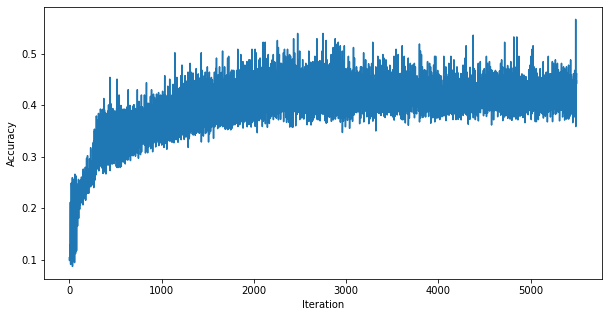

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

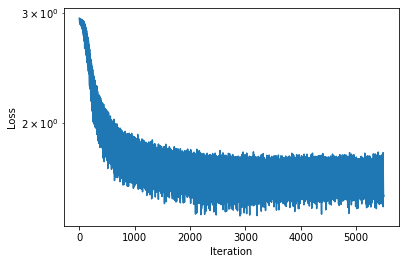

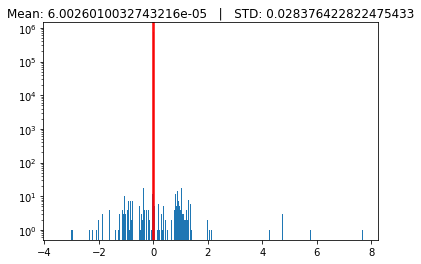

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 9.476190476190476


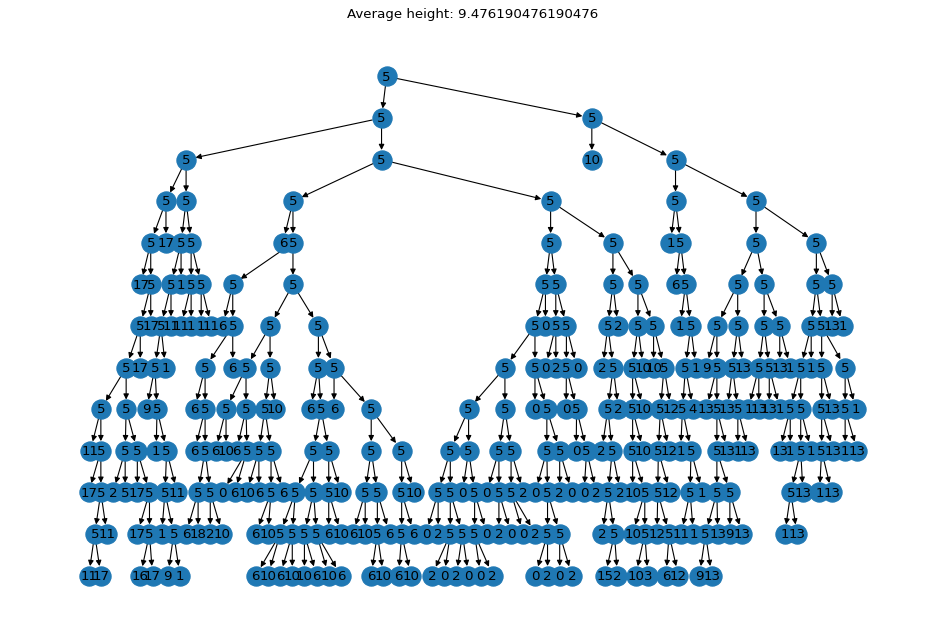

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 168


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

16515
============== Pattern 1 ==============
34
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
321
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
552
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
========

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 87 ==============
============== Pattern 88 ==============
============== Pattern 89 ==============
============== Pattern 90 ==============
============== Pattern 91 ==============
============== Pattern 92 ==============
============== Pattern 93 ==============
============== Pattern 94 ==============
============== Pattern 95 ==============
============== Pattern 96 ==============
============== Pattern 97 ==============
============== Pattern 98 ==============
============== Pattern 99 ==============
============== Pattern 100 ==============
============== Pattern 101 ==============
============== Pattern 102 ==============
============== Pattern 103 ==============
============== Pattern 104 ==============
============== Pattern 105 ==============
============== Pattern 106 ==============
============== Pattern 107 ==============
============== Pattern 108 ==============
============== Pattern 109 ==============
============== Pattern 110 ==============
=====